In [2]:
import numpy as np
from astropy.cosmology import WMAP9 as cosmo
import yt
import glob
import matplotlib.pyplot as plt
from scipy import interpolate

In [2]:
def parse_ionDens(numberDens,ionicFrac):
    # input numberDens=[nH, nHe]
    # input ionicFrac=[xHI, xHeI, xHeII]
    # return nHI,nHII,nHeI,nHeII,nHeIII,ne,ntot
    nHI=numberDens[0]*ionicFrac[0]
    nHII=numberDens[0]*(1-ionicFrac[0])
    nHeI=numberDens[1]*ionicFrac[1]
    nHeII=numberDens[1]*ionicFrac[2]
    nHeIII=numberDens[1]*(1-ionicFrac[1]-ionicFrac[2])
    ne=nHII+nHeII+2*nHeIII
    ntot=numberDens[0]+numberDens[1]+ne
    return nHI,nHII,nHeI,nHeII,nHeIII,ne,ntot


def sigma_HI_nu(nu):
    # atomic data: photo-ionization xsec of HI 
    # input nu in eV (> 13.6 eV!!! only works when nu>nuHI)
    # output sigma_HI in cm^2
    nuHI=13.6
    sigma_HI=6.30e-18*(1.34*(nu/nuHI)**-2.99-0.34*(nu/nuHI)**-3.99) #cm**2
    return sigma_HI

def sigma_HeI_nu(nu):
    # input nu in eV (> 24.6 eV!!!)
    nuHeI=24.6
    sigma_HI=7.03e-18*(1.66*(nu/nuHeI)**-2.05-0.66*(nu/nuHeI)**-3.05) #cm**2
    return sigma_HI

def sigma_HeII_nu(nu):
    # input nu in eV (> 54.4 eV!!!)
    nuHeII=54.4
    sigma_HI=1.50e-18*(1.34*(nu/nuHeII)**-2.99-0.34*(nu/nuHeII)**-3.99) #cm**2
    return sigma_HI

def ion_potential(species):
    ionpdict={'HI':13.6,'HeI':24.6,'HeII':54.4}
    return ionpdict[species]

def sigma_nu(nu,species):
    sigmadict={'HI':sigma_HI_nu,'HeI':sigma_HeI_nu,'HeII':sigma_HeII_nu}
    return sigmadict[species](nu)
    
def eGamma_HI(T):
    T5=T/1e5
    eGamma=1.17e-10*T**0.5*np.exp(-157809.1/T)/(1+T5**0.5)
    return eGamma

def eGamma_HeI(T):
    T5=T/1e5
    eGamma=4.76e-11*T**0.5*np.exp(-285335.4/T)/(1+T5**0.5)
    return eGamma

def eGamma_HeII(T):
    T5=T/1e5
    eGamma=1.14e-11*T**0.5*np.exp(-631515.0/T)/(1+T5**0.5)
    return eGamma

def colli_ioniz_rate(T,species):
    eGammaDict={'HI':eGamma_HI,'HeI':eGamma_HeI,'HeII':eGamma_HeII}
    return eGammaDict[species](T)

def alphaA_HI_Abel97(T):
    ### fit doesn't work for T>1e6K
    T_eV=T*8.61733e-5
    recHI=np.exp(-28.6130338 - 0.72411256*np.log(T_eV) - 2.02604473e-2*np.log(T_eV)**2
        - 2.38086188e-3*np.log(T_eV)**3 - 3.21260521e-4*np.log(T_eV)**4 - 1.42150291e-5*np.log(T_eV)**5
        + 4.98910892e-6*np.log(T_eV)**6 + 5.75561414e-7*np.log(T_eV)**7 - 1.85676704e-8*np.log(T_eV)**8
        - 3.07113524e-9*np.log(T_eV)**9)
    return recHI

def alpha_r_HeI_Abel97(T):
    ### radiative recombination, 10% error within 1e3-1e5 K, terrible outside
    T_eV=T*8.61733e-5
    return (3.925e-13*T_eV**-0.6353)
   
def alpha_d_HeI_Abel97(T):
    ### dielectronic recombination
    ### !!! more than a factor of 2 different above 1e5 K
    T_eV=T*8.61733e-5
    drecHeI=1.544e-9*T_eV**-1.5*np.exp(-48.596/T_eV)*(0.3+np.exp(8.1/T_eV))
    drecHeI[T<1e3]=0;
    return drecHeI

def alpha_HeI_Abel97(T):
    return (alpha_r_HeI_Abel97(T)+alpha_d_HeI_Abel97(T))

def alpha_HeII_Abel97(T):
    return (2*alphaA_HI_Abel97(T/4))

def recomb_rate(T,species):
    alphadict={'HI':alphaA_HI_Abel97,'HeI':alpha_HeI_Abel97,'HeII':alpha_HeII_Abel97, \
                "HeI_r":alpha_r_HeI_Abel97, "HeI_d":alpha_d_HeI_Abel97}
    return alphadict[species](T)

def init_photo_bkg(los):
    T=los["T"]
    nH=los["nH"]
    nHe=los["nHe"]
    xHI=los["xHI"]
    xHeI=los["xHeI"]
    xHeII=los["xHeII"]
    nHI,nHII,nHeI,nHeII,nHeIII,ne,ntot=parse_ionDens([nH,nHe],[xHI,xHeI,xHeII,T]) 
    Gamma_HI=recomb_rate(T,"HI")*(1-xHI)*ne/xHI-ne*eGamma_HI(T)
    Gamma_HeI=recomb_rate(T,"HeI")*(xHeII)*ne/xHeI-ne*eGamma_HeI(T)
    Gamma_HeII=recomb_rate(T,"HeII")*(1-xHeI-xHeII)*ne/xHeII-ne*eGamma_HeII(T)

    Gamma_HI[Gamma_HI<0]=0
    Gamma_HeI[Gamma_HeI<0]=0
    Gamma_HeII[Gamma_HeII<0]=0
    Heating_bkg=np.array([np.zeros_like(T),np.zeros_like(T),np.zeros_like(T)])
    return np.array([Gamma_HI,Gamma_HeI,Gamma_HeII]),Heating_bkg

In [3]:
1./0.1401-1

6.137758743754461

In [4]:
rootpath="/data/hqchen/mfp_project/data/"
folder="F_a0.1401_50pMpc/"
zuni=1/0.1401-1
Hz=cosmo.H(zuni).value


# uniformly sample

In [26]:
sample_dist=np.linspace(1,49,4801)
sample_dist

array([ 1.  ,  1.01,  1.02, ..., 48.98, 48.99, 49.  ])

In [32]:
gammalist=[]
# dr=[]
losList=glob.glob(rootpath+folder+"lightray*h5")
for losName in losList[:]:
    lr=yt.load(losName)
    los={}
    los["T"]=lr.r['temperature'].in_units("K").v
    los["nH"]=((lr.r['gas','RT_HVAR_HI']+lr.r['gas','RT_HVAR_HII'])/yt.units.mp).in_units("cm**-3").v
    los["nHe"]=((lr.r['gas','RT_HVAR_HeI']+lr.r['gas','RT_HVAR_HeII']+lr.r['gas','RT_HVAR_HeIII'])/yt.units.mp/4).in_units("cm**-3").v
    los["xHI"]=lr.r['gas','RT_HVAR_HI']/(lr.r['gas','RT_HVAR_HI']+lr.r['gas','RT_HVAR_HII'])
    los["xHeI"]=lr.r['gas','RT_HVAR_HeI']/(lr.r['gas','RT_HVAR_HeI']+lr.r['gas','RT_HVAR_HeII']+lr.r['gas','RT_HVAR_HeIII'])
    los["xHeII"]=lr.r['gas','RT_HVAR_HeII']/(lr.r['gas','RT_HVAR_HeI']+lr.r['gas','RT_HVAR_HeII']+lr.r['gas','RT_HVAR_HeIII'])
    gamma=init_photo_bkg(los)[0][0]
    dist=np.cumsum(lr.r['dl'].in_units("Mpc").v)
    func=interpolate.interp1d(dist,gamma)
    gammalist+=list(func(sample_dist))
    
#     dr+=list(lr.r['dl'].v)
#     plt.plot(init_photo_bkg(los)[0][0],alpha=0.1,c='b')
# # plt.yscale("log")
# plt.ylim(1e-13,2e-13)
# plt.grid()

yt : [INFO     ] 2024-03-07 10:07:37,359 Parameters: current_time              = 906321765.4078646 yr
yt : [INFO     ] 2024-03-07 10:07:37,360 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-03-07 10:07:37,361 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-03-07 10:07:37,362 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-03-07 10:07:37,363 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-03-07 10:07:37,364 Parameters: current_redshift          = 6.140301583811697
yt : [INFO     ] 2024-03-07 10:07:37,365 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-03-07 10:07:37,365 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-03-07 10:07:37,366 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-03-07 10:07:37,367 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     

yt : [INFO     ] 2024-03-07 10:07:40,042 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-03-07 10:07:40,043 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-03-07 10:07:40,044 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-03-07 10:07:40,045 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-03-07 10:07:40,046 Parameters: current_redshift          = 6.140301583811697
yt : [INFO     ] 2024-03-07 10:07:40,047 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-03-07 10:07:40,047 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-03-07 10:07:40,048 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-03-07 10:07:40,049 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-03-07 10:07:40,054 Allocating for 8.258e+03 particles (index particle type 'all')
yt : [INFO   

yt : [INFO     ] 2024-03-07 10:07:42,565 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-03-07 10:07:42,566 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-03-07 10:07:42,567 Parameters: current_redshift          = 6.140301583811697
yt : [INFO     ] 2024-03-07 10:07:42,567 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-03-07 10:07:42,568 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-03-07 10:07:42,569 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-03-07 10:07:42,569 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-03-07 10:07:42,575 Allocating for 7.059e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-03-07 10:07:42,580 Identified 4.465e+03 octs
yt : [INFO     ] 2024-03-07 10:07:42,896 Parameters: current_time              = 906321765.4078646 yr
yt : [INFO     ] 2024-03-07 10:07:42,

yt : [INFO     ] 2024-03-07 10:07:45,073 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-03-07 10:07:45,073 Parameters: current_redshift          = 6.140301583811697
yt : [INFO     ] 2024-03-07 10:07:45,074 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-03-07 10:07:45,075 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-03-07 10:07:45,075 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-03-07 10:07:45,076 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-03-07 10:07:45,081 Allocating for 6.670e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-03-07 10:07:45,087 Identified 4.601e+03 octs
yt : [INFO     ] 2024-03-07 10:07:45,411 Parameters: current_time              = 906321765.4078646 yr
yt : [INFO     ] 2024-03-07 10:07:45,412 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-03-07 10:07:45,413 Parameters: domai

yt : [INFO     ] 2024-03-07 10:07:47,556 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-03-07 10:07:47,557 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-03-07 10:07:47,557 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-03-07 10:07:47,558 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-03-07 10:07:47,563 Allocating for 6.088e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-03-07 10:07:47,569 Identified 4.361e+03 octs
yt : [INFO     ] 2024-03-07 10:07:48,025 Parameters: current_time              = 906321765.4078646 yr
yt : [INFO     ] 2024-03-07 10:07:48,026 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-03-07 10:07:48,027 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-03-07 10:07:48,028 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-03-07 1

yt : [ERROR    ] 2024-03-07 10:07:50,207 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-03-07 10:07:50,207 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-03-07 10:07:50,213 Allocating for 8.364e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-03-07 10:07:50,219 Identified 5.385e+03 octs
yt : [INFO     ] 2024-03-07 10:07:50,536 Parameters: current_time              = 906321765.4078646 yr
yt : [INFO     ] 2024-03-07 10:07:50,537 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-03-07 10:07:50,538 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-03-07 10:07:50,538 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-03-07 10:07:50,539 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-03-07 10:07:50,540 Parameters: current_redshift          = 6.140301583811697
yt : [INFO     ] 2024-03-07 10:07:50,540 Par

yt : [INFO     ] 2024-03-07 10:07:53,248 Allocating for 8.036e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-03-07 10:07:53,254 Identified 5.361e+03 octs
yt : [INFO     ] 2024-03-07 10:07:53,578 Parameters: current_time              = 906321765.4078646 yr
yt : [INFO     ] 2024-03-07 10:07:53,579 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-03-07 10:07:53,579 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-03-07 10:07:53,580 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-03-07 10:07:53,581 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-03-07 10:07:53,582 Parameters: current_redshift          = 6.140301583811697
yt : [INFO     ] 2024-03-07 10:07:53,582 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-03-07 10:07:53,583 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-03-07 10:07:53,58

yt : [INFO     ] 2024-03-07 10:07:55,776 Identified 4.913e+03 octs
yt : [INFO     ] 2024-03-07 10:07:56,091 Parameters: current_time              = 906321765.4078646 yr
yt : [INFO     ] 2024-03-07 10:07:56,091 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-03-07 10:07:56,092 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-03-07 10:07:56,093 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-03-07 10:07:56,094 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-03-07 10:07:56,095 Parameters: current_redshift          = 6.140301583811697
yt : [INFO     ] 2024-03-07 10:07:56,095 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-03-07 10:07:56,096 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-03-07 10:07:56,097 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-03-07 10:07:56,097 Paramet

yt : [INFO     ] 2024-03-07 10:07:59,019 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-03-07 10:07:59,020 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-03-07 10:07:59,021 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-03-07 10:07:59,022 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-03-07 10:07:59,023 Parameters: current_redshift          = 6.140301583811697
yt : [INFO     ] 2024-03-07 10:07:59,023 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-03-07 10:07:59,024 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-03-07 10:07:59,025 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-03-07 10:07:59,025 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-03-07 10:07:59,031 Allocating for 6.031e+03 particles (index particle type 'all')
yt : [INFO   

yt : [INFO     ] 2024-03-07 10:08:01,338 Identified 4.337e+03 octs
yt : [INFO     ] 2024-03-07 10:08:01,700 Parameters: current_time              = 906321765.4078646 yr
yt : [INFO     ] 2024-03-07 10:08:01,701 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-03-07 10:08:01,701 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-03-07 10:08:01,702 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-03-07 10:08:01,703 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-03-07 10:08:01,704 Parameters: current_redshift          = 6.140301583811697
yt : [INFO     ] 2024-03-07 10:08:01,705 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-03-07 10:08:01,705 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-03-07 10:08:01,706 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-03-07 10:08:01,707 Paramet

yt : [INFO     ] 2024-03-07 10:08:04,196 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-03-07 10:08:04,197 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-03-07 10:08:04,198 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-03-07 10:08:04,198 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-03-07 10:08:04,199 Parameters: current_redshift          = 6.140301583811697
yt : [INFO     ] 2024-03-07 10:08:04,200 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-03-07 10:08:04,200 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-03-07 10:08:04,201 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-03-07 10:08:04,202 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-03-07 10:08:04,207 Allocating for 7.826e+03 particles (index particle type 'all')
yt : [INFO   

yt : [INFO     ] 2024-03-07 10:08:06,847 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-03-07 10:08:06,848 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-03-07 10:08:06,848 Parameters: current_redshift          = 6.140301583811697
yt : [INFO     ] 2024-03-07 10:08:06,849 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-03-07 10:08:06,849 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-03-07 10:08:06,850 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-03-07 10:08:06,851 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-03-07 10:08:06,856 Allocating for 8.483e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-03-07 10:08:06,862 Identified 5.449e+03 octs
yt : [INFO     ] 2024-03-07 10:08:07,195 Parameters: current_time              = 906321765.4078646 yr
yt : [INFO     ] 2024-03-07 10:08:07,

yt : [INFO     ] 2024-03-07 10:08:09,585 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-03-07 10:08:09,586 Parameters: current_redshift          = 6.140301583811697
yt : [INFO     ] 2024-03-07 10:08:09,586 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-03-07 10:08:09,587 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-03-07 10:08:09,587 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-03-07 10:08:09,588 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-03-07 10:08:09,593 Allocating for 7.003e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-03-07 10:08:09,599 Identified 4.561e+03 octs
yt : [INFO     ] 2024-03-07 10:08:09,925 Parameters: current_time              = 906321765.4078646 yr
yt : [INFO     ] 2024-03-07 10:08:09,926 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-03-07 10:08:09,927 Parameters: domai

yt : [INFO     ] 2024-03-07 10:08:12,376 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-03-07 10:08:12,377 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-03-07 10:08:12,377 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-03-07 10:08:12,378 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-03-07 10:08:12,384 Allocating for 6.871e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-03-07 10:08:12,389 Identified 4.577e+03 octs
yt : [INFO     ] 2024-03-07 10:08:12,706 Parameters: current_time              = 906321765.4078646 yr
yt : [INFO     ] 2024-03-07 10:08:12,707 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-03-07 10:08:12,708 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-03-07 10:08:12,709 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-03-07 1

yt : [ERROR    ] 2024-03-07 10:08:14,914 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-03-07 10:08:14,914 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-03-07 10:08:14,920 Allocating for 8.160e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-03-07 10:08:14,926 Identified 5.465e+03 octs
yt : [INFO     ] 2024-03-07 10:08:15,260 Parameters: current_time              = 906321765.4078646 yr
yt : [INFO     ] 2024-03-07 10:08:15,260 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-03-07 10:08:15,261 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-03-07 10:08:15,262 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-03-07 10:08:15,263 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-03-07 10:08:15,263 Parameters: current_redshift          = 6.140301583811697
yt : [INFO     ] 2024-03-07 10:08:15,264 Par

yt : [INFO     ] 2024-03-07 10:08:17,653 Allocating for 7.945e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-03-07 10:08:17,658 Identified 5.257e+03 octs
yt : [INFO     ] 2024-03-07 10:08:17,983 Parameters: current_time              = 906321765.4078646 yr
yt : [INFO     ] 2024-03-07 10:08:17,984 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-03-07 10:08:17,985 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-03-07 10:08:17,986 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-03-07 10:08:17,986 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-03-07 10:08:17,987 Parameters: current_redshift          = 6.140301583811697
yt : [INFO     ] 2024-03-07 10:08:17,988 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-03-07 10:08:17,988 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-03-07 10:08:17,98

yt : [INFO     ] 2024-03-07 10:08:20,198 Identified 4.673e+03 octs
yt : [INFO     ] 2024-03-07 10:08:20,511 Parameters: current_time              = 906321765.4078646 yr
yt : [INFO     ] 2024-03-07 10:08:20,512 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-03-07 10:08:20,513 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-03-07 10:08:20,514 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-03-07 10:08:20,514 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-03-07 10:08:20,515 Parameters: current_redshift          = 6.140301583811697
yt : [INFO     ] 2024-03-07 10:08:20,516 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-03-07 10:08:20,516 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-03-07 10:08:20,517 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-03-07 10:08:20,518 Paramet

yt : [INFO     ] 2024-03-07 10:08:23,167 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-03-07 10:08:23,168 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-03-07 10:08:23,169 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-03-07 10:08:23,170 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-03-07 10:08:23,170 Parameters: current_redshift          = 6.140301583811697
yt : [INFO     ] 2024-03-07 10:08:23,171 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-03-07 10:08:23,172 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-03-07 10:08:23,172 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-03-07 10:08:23,173 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-03-07 10:08:23,179 Allocating for 6.940e+03 particles (index particle type 'all')
yt : [INFO   

yt : [INFO     ] 2024-03-07 10:08:25,724 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-03-07 10:08:25,725 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-03-07 10:08:25,726 Parameters: current_redshift          = 6.140301583811697
yt : [INFO     ] 2024-03-07 10:08:25,727 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-03-07 10:08:25,727 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-03-07 10:08:25,728 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-03-07 10:08:25,729 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-03-07 10:08:25,734 Allocating for 7.180e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-03-07 10:08:25,740 Identified 4.793e+03 octs
yt : [INFO     ] 2024-03-07 10:08:26,061 Parameters: current_time              = 906321765.4078646 yr
yt : [INFO     ] 2024-03-07 10:08:26,

yt : [INFO     ] 2024-03-07 10:08:28,247 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-03-07 10:08:28,248 Parameters: current_redshift          = 6.140301583811697
yt : [INFO     ] 2024-03-07 10:08:28,249 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-03-07 10:08:28,249 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-03-07 10:08:28,250 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-03-07 10:08:28,251 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-03-07 10:08:28,256 Allocating for 7.565e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-03-07 10:08:28,262 Identified 5.073e+03 octs
yt : [INFO     ] 2024-03-07 10:08:28,581 Parameters: current_time              = 906321765.4078646 yr
yt : [INFO     ] 2024-03-07 10:08:28,582 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-03-07 10:08:28,583 Parameters: domai

yt : [INFO     ] 2024-03-07 10:08:30,751 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-03-07 10:08:30,751 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-03-07 10:08:30,752 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-03-07 10:08:30,753 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-03-07 10:08:30,758 Allocating for 7.406e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-03-07 10:08:30,764 Identified 5.033e+03 octs
yt : [INFO     ] 2024-03-07 10:08:31,089 Parameters: current_time              = 906321765.4078646 yr
yt : [INFO     ] 2024-03-07 10:08:31,090 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-03-07 10:08:31,090 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-03-07 10:08:31,091 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-03-07 1

yt : [ERROR    ] 2024-03-07 10:08:33,252 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-03-07 10:08:33,253 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-03-07 10:08:33,258 Allocating for 6.869e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-03-07 10:08:33,264 Identified 4.785e+03 octs
yt : [INFO     ] 2024-03-07 10:08:33,588 Parameters: current_time              = 906321765.4078646 yr
yt : [INFO     ] 2024-03-07 10:08:33,589 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-03-07 10:08:33,590 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-03-07 10:08:33,591 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-03-07 10:08:33,592 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-03-07 10:08:33,592 Parameters: current_redshift          = 6.140301583811697
yt : [INFO     ] 2024-03-07 10:08:33,593 Par

yt : [INFO     ] 2024-03-07 10:08:35,788 Allocating for 6.696e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-03-07 10:08:35,793 Identified 4.361e+03 octs
yt : [INFO     ] 2024-03-07 10:08:36,099 Parameters: current_time              = 906321765.4078646 yr
yt : [INFO     ] 2024-03-07 10:08:36,100 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-03-07 10:08:36,101 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-03-07 10:08:36,101 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-03-07 10:08:36,102 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-03-07 10:08:36,103 Parameters: current_redshift          = 6.140301583811697
yt : [INFO     ] 2024-03-07 10:08:36,103 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-03-07 10:08:36,104 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-03-07 10:08:36,10

yt : [INFO     ] 2024-03-07 10:08:38,282 Identified 5.289e+03 octs
yt : [INFO     ] 2024-03-07 10:08:38,594 Parameters: current_time              = 906321765.4078646 yr
yt : [INFO     ] 2024-03-07 10:08:38,595 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-03-07 10:08:38,596 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-03-07 10:08:38,597 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-03-07 10:08:38,597 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-03-07 10:08:38,598 Parameters: current_redshift          = 6.140301583811697
yt : [INFO     ] 2024-03-07 10:08:38,599 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-03-07 10:08:38,599 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-03-07 10:08:38,600 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-03-07 10:08:38,601 Paramet

KeyboardInterrupt: 

In [23]:
len(lr.r['dl'])

7886

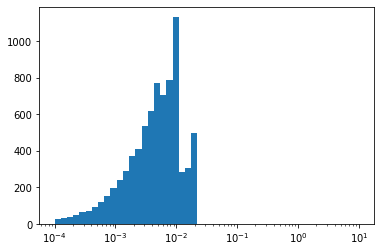

In [20]:
plt.hist(lr.r['dl'].in_units("Mpc").v,bins=np.logspace(-4,1))
plt.xscale("log")

In [5]:
# gammalist=[]
# dr=[]
# losList=glob.glob(rootpath+folder+"lightray*h5")
# for losName in losList[:]:
#     lr=yt.load(losName)
#     los={}
#     los["T"]=lr.r['temperature'].in_units("K").v
#     los["nH"]=((lr.r['gas','RT_HVAR_HI']+lr.r['gas','RT_HVAR_HII'])/yt.units.mp).in_units("cm**-3").v
#     los["nHe"]=((lr.r['gas','RT_HVAR_HeI']+lr.r['gas','RT_HVAR_HeII']+lr.r['gas','RT_HVAR_HeIII'])/yt.units.mp/4).in_units("cm**-3").v
#     los["xHI"]=lr.r['gas','RT_HVAR_HI']/(lr.r['gas','RT_HVAR_HI']+lr.r['gas','RT_HVAR_HII'])
#     los["xHeI"]=lr.r['gas','RT_HVAR_HeI']/(lr.r['gas','RT_HVAR_HeI']+lr.r['gas','RT_HVAR_HeII']+lr.r['gas','RT_HVAR_HeIII'])
#     los["xHeII"]=lr.r['gas','RT_HVAR_HeII']/(lr.r['gas','RT_HVAR_HeI']+lr.r['gas','RT_HVAR_HeII']+lr.r['gas','RT_HVAR_HeIII'])
#     gammalist+=list(init_photo_bkg(los)[0][0])
#     dr+=list(lr.r['dl'].v)
# #     plt.plot(init_photo_bkg(los)[0][0],alpha=0.1,c='b')
# # # plt.yscale("log")
# # plt.ylim(1e-13,2e-13)
# # plt.grid()

yt : [INFO     ] 2024-03-07 09:57:24,725 Parameters: current_time              = 906321765.4078646 yr
yt : [INFO     ] 2024-03-07 09:57:24,727 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-03-07 09:57:24,728 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-03-07 09:57:24,729 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-03-07 09:57:24,730 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-03-07 09:57:24,731 Parameters: current_redshift          = 6.140301583811697
yt : [INFO     ] 2024-03-07 09:57:24,731 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-03-07 09:57:24,732 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-03-07 09:57:24,733 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-03-07 09:57:24,734 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     

Traceback (most recent call last):
  File "/data/hqchen/software/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-5-cd094e0fc802>", line 5, in <module>
    lr=yt.load(losName)
  File "/data/hqchen/software/anaconda3/lib/python3.7/site-packages/yt/convenience.py", line 86, in load
    return candidates[0](*args, **kwargs)
  File "/data/hqchen/software/anaconda3/lib/python3.7/site-packages/yt/frontends/ytdata/data_structures.py", line 244, in __init__
    units_override=units_override, unit_system=unit_system)
  File "/data/hqchen/software/anaconda3/lib/python3.7/site-packages/yt/data_objects/static_output.py", line 249, in __init__
    self._parse_parameter_file()
  File "/data/hqchen/software/anaconda3/lib/python3.7/site-packages/yt/frontends/ytdata/data_structures.py", line 307, in _parse_parameter_file
    super(YTDataLightRayDataset, self)._parse_parameter_file

KeyboardInterrupt: 

In [12]:
np.save("gamma_bkg_z61.npy",gammalist)
np.save("gamma_bkg_z61_dr.npy",dr)

In [4]:
np.median(gammalist)

In [13]:
val61,bine=np.histogram(gamma_bkg_z61,bins=np.logspace(-15,-10),weights=dr)


In [3]:
plt.rcParams["text.usetex"]=True
plt.rcParams["axes.labelsize"]=20
plt.rcParams["xtick.labelsize"]=20
plt.rcParams["ytick.labelsize"]=20
plt.rcParams["legend.fontsize"]=20

In [16]:
((bine[1:]+bine[:-1])/2.)[val61==np.max(val61)]

array([1.24401832e-13])

Text(0.5, 0, '$\\Gamma_{\\rm bkg} \\ [\\rm s^{-1}]$')

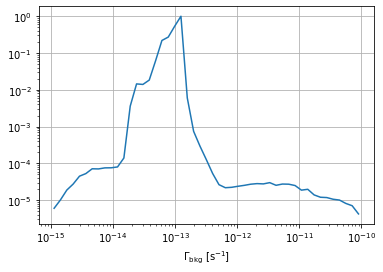

In [15]:
plt.plot((bine[1:]+bine[:-1])/2.,val61/np.max(val61))

plt.loglog()
plt.grid()
plt.xlabel(r"$\Gamma_{\rm bkg} \ [\rm s^{-1}]$")

In [21]:
1/0.16-1

5.25

In [23]:
rootpath="/data/hqchen/mfp_project/data/"
folder="F_a0.1606_50pMpc/"
zuni=1/0.1606-1
Hz=cosmo.H(zuni).value


In [24]:
gammalist_z525=[]
dr_z525=[]
losList=glob.glob(rootpath+folder+"lightray*h5")
for losName in losList[:]:
    lr=yt.load(losName)
    los={}
    los["T"]=lr.r['temperature'].in_units("K").v
    los["nH"]=((lr.r['gas','RT_HVAR_HI']+lr.r['gas','RT_HVAR_HII'])/yt.units.mp).in_units("cm**-3").v
    los["nHe"]=((lr.r['gas','RT_HVAR_HeI']+lr.r['gas','RT_HVAR_HeII']+lr.r['gas','RT_HVAR_HeIII'])/yt.units.mp/4).in_units("cm**-3").v
    los["xHI"]=lr.r['gas','RT_HVAR_HI']/(lr.r['gas','RT_HVAR_HI']+lr.r['gas','RT_HVAR_HII'])
    los["xHeI"]=lr.r['gas','RT_HVAR_HeI']/(lr.r['gas','RT_HVAR_HeI']+lr.r['gas','RT_HVAR_HeII']+lr.r['gas','RT_HVAR_HeIII'])
    los["xHeII"]=lr.r['gas','RT_HVAR_HeII']/(lr.r['gas','RT_HVAR_HeI']+lr.r['gas','RT_HVAR_HeII']+lr.r['gas','RT_HVAR_HeIII'])
    gammalist_z525+=list(init_photo_bkg(los)[0][0])
    dr_z525+=list(lr.r['dl'].v)
#     plt.plot(init_photo_bkg(los)[0][0],alpha=0.1,c='b')
# # plt.yscale("log")
# plt.ylim(1e-13,2e-13)
# plt.grid()

yt : [INFO     ] 2024-02-06 16:11:41,775 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:11:41,776 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:11:41,777 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:11:41,778 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:11:41,779 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:11:41,779 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:11:41,780 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:11:41,780 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:11:41,781 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:11:41,781 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO   

yt : [INFO     ] 2024-02-06 16:11:46,361 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:11:46,362 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:11:46,363 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:11:46,364 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:11:46,365 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:11:46,366 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:11:46,366 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:11:46,367 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:11:46,368 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:11:46,381 Allocating for 6.544e+03 particles (index particle type 'all')
yt : [INFO  

yt : [INFO     ] 2024-02-06 16:11:50,447 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:11:50,448 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:11:50,448 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:11:50,449 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:11:50,449 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:11:50,450 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:11:50,450 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:11:50,451 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:11:50,457 Allocating for 5.316e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:11:50,465 Identified 3.697e+03 octs
yt : [INFO     ] 2024-02-06 16:11:

yt : [INFO     ] 2024-02-06 16:11:54,373 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:11:54,375 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:11:54,376 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:11:54,377 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:11:54,378 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:11:54,379 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:11:54,380 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:11:54,389 Allocating for 5.918e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:11:54,399 Identified 3.937e+03 octs
yt : [INFO     ] 2024-02-06 16:11:54,881 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:11:5

yt : [INFO     ] 2024-02-06 16:11:57,911 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:11:57,912 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:11:57,913 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:11:57,914 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:11:57,916 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:11:57,917 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:11:57,924 Allocating for 5.390e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:11:57,933 Identified 3.673e+03 octs
yt : [INFO     ] 2024-02-06 16:11:58,905 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:11:58,906 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:11:58,907 Parameters: dom

yt : [INFO     ] 2024-02-06 16:12:01,693 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:12:01,693 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:12:01,694 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:12:01,695 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:12:01,702 Allocating for 5.750e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:12:01,711 Identified 3.921e+03 octs
yt : [INFO     ] 2024-02-06 16:12:02,116 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:12:02,117 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:12:02,118 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:12:02,119 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 

yt : [INFO     ] 2024-02-06 16:12:05,681 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:12:05,682 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:12:05,683 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:12:05,690 Allocating for 5.843e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:12:05,700 Identified 4.041e+03 octs
yt : [INFO     ] 2024-02-06 16:12:06,142 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:12:06,143 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:12:06,144 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:12:06,145 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:12:06,146 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:12:06,146 P

yt : [ERROR    ] 2024-02-06 16:12:09,692 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:12:09,692 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:12:09,700 Allocating for 5.988e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:12:09,719 Identified 4.009e+03 octs
yt : [INFO     ] 2024-02-06 16:12:10,151 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:12:10,152 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:12:10,153 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:12:10,153 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:12:10,154 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:12:10,154 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:12:10,155 P

yt : [INFO     ] 2024-02-06 16:12:12,838 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:12:12,844 Allocating for 6.148e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:12:12,853 Identified 3.825e+03 octs
yt : [INFO     ] 2024-02-06 16:12:13,720 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:12:13,721 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:12:13,722 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:12:13,722 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:12:13,723 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:12:13,724 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:12:13,725 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:12:13,

yt : [INFO     ] 2024-02-06 16:12:16,287 Allocating for 6.058e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:12:16,296 Identified 4.001e+03 octs
yt : [INFO     ] 2024-02-06 16:12:16,694 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:12:16,694 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:12:16,695 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:12:16,696 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:12:16,697 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:12:16,697 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:12:16,698 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:12:16,698 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:12:16,

yt : [INFO     ] 2024-02-06 16:12:19,759 Identified 4.033e+03 octs
yt : [INFO     ] 2024-02-06 16:12:20,159 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:12:20,160 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:12:20,161 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:12:20,162 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:12:20,163 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:12:20,163 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:12:20,164 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:12:20,165 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:12:20,165 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:12:20,166 Param

yt : [INFO     ] 2024-02-06 16:12:23,631 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:12:23,631 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:12:23,632 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:12:23,633 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:12:23,634 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:12:23,634 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:12:23,635 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:12:23,635 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:12:23,636 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:12:23,643 Allocating for 6.597e+03 particles (index particle type 'all')
yt : [INFO  

yt : [INFO     ] 2024-02-06 16:12:27,071 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:12:27,072 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:12:27,073 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:12:27,073 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:12:27,074 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:12:27,075 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:12:27,075 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:12:27,076 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:12:27,083 Allocating for 6.053e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:12:27,140 Identified 4.137e+03 octs
yt : [INFO     ] 2024-02-06 16:12:

yt : [INFO     ] 2024-02-06 16:12:30,097 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:12:30,098 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:12:30,098 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:12:30,099 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:12:30,100 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:12:30,100 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:12:30,101 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:12:30,107 Allocating for 7.040e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:12:30,131 Identified 4.601e+03 octs
yt : [INFO     ] 2024-02-06 16:12:30,518 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:12:3

yt : [INFO     ] 2024-02-06 16:12:33,497 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:12:33,498 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:12:33,498 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:12:33,499 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:12:33,499 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:12:33,500 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:12:33,508 Allocating for 5.652e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:12:33,516 Identified 3.745e+03 octs
yt : [INFO     ] 2024-02-06 16:12:33,921 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:12:33,922 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:12:33,923 Parameters: dom

yt : [INFO     ] 2024-02-06 16:12:36,867 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:12:36,867 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:12:36,868 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:12:36,869 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:12:36,876 Allocating for 4.643e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:12:36,891 Identified 3.265e+03 octs
yt : [INFO     ] 2024-02-06 16:12:37,298 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:12:37,299 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:12:37,299 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:12:37,300 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 

yt : [INFO     ] 2024-02-06 16:12:40,001 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:12:40,001 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:12:40,002 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:12:40,010 Allocating for 6.999e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:12:40,019 Identified 4.665e+03 octs
yt : [INFO     ] 2024-02-06 16:12:41,073 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:12:41,074 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:12:41,075 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:12:41,075 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:12:41,076 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:12:41,077 P

yt : [ERROR    ] 2024-02-06 16:12:43,788 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:12:43,789 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:12:43,798 Allocating for 5.796e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:12:43,809 Identified 4.041e+03 octs
yt : [INFO     ] 2024-02-06 16:12:44,206 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:12:44,207 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:12:44,208 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:12:44,209 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:12:44,210 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:12:44,211 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:12:44,211 P

yt : [INFO     ] 2024-02-06 16:12:47,532 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:12:47,541 Allocating for 6.539e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:12:47,558 Identified 4.433e+03 octs
yt : [INFO     ] 2024-02-06 16:12:47,953 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:12:47,954 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:12:47,955 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:12:47,956 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:12:47,957 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:12:47,958 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:12:47,958 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:12:47,

yt : [INFO     ] 2024-02-06 16:12:51,538 Allocating for 6.936e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:12:51,555 Identified 4.609e+03 octs
yt : [INFO     ] 2024-02-06 16:12:51,995 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:12:51,996 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:12:51,997 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:12:51,998 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:12:51,999 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:12:51,999 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:12:52,000 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:12:52,001 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:12:52,

yt : [INFO     ] 2024-02-06 16:12:54,790 Identified 4.625e+03 octs
yt : [INFO     ] 2024-02-06 16:12:55,205 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:12:55,206 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:12:55,206 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:12:55,207 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:12:55,208 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:12:55,208 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:12:55,209 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:12:55,209 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:12:55,210 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:12:55,211 Param

yt : [INFO     ] 2024-02-06 16:12:58,922 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:12:58,923 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:12:58,923 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:12:58,924 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:12:58,925 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:12:58,925 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:12:58,926 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:12:58,926 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:12:58,927 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:12:58,933 Allocating for 7.332e+03 particles (index particle type 'all')
yt : [INFO  

yt : [INFO     ] 2024-02-06 16:13:02,790 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:13:02,791 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:13:02,792 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:13:02,793 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:13:02,794 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:13:02,794 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:13:02,795 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:13:02,796 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:13:02,807 Allocating for 5.737e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:13:02,829 Identified 3.737e+03 octs
yt : [INFO     ] 2024-02-06 16:13:

yt : [INFO     ] 2024-02-06 16:13:06,763 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:13:06,764 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:13:06,764 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:13:06,765 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:13:06,765 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:13:06,766 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:13:06,767 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:13:06,774 Allocating for 5.868e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:13:06,785 Identified 3.897e+03 octs
yt : [INFO     ] 2024-02-06 16:13:07,228 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:13:0

yt : [INFO     ] 2024-02-06 16:13:10,186 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:13:10,187 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:13:10,187 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:13:10,188 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:13:10,188 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:13:10,189 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:13:10,196 Allocating for 6.823e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:13:10,206 Identified 4.625e+03 octs
yt : [INFO     ] 2024-02-06 16:13:10,653 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:13:10,653 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:13:10,654 Parameters: dom

yt : [INFO     ] 2024-02-06 16:13:14,019 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:13:14,020 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:13:14,021 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:13:14,021 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:13:14,029 Allocating for 7.100e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:13:14,037 Identified 4.785e+03 octs
yt : [INFO     ] 2024-02-06 16:13:14,456 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:13:14,457 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:13:14,458 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:13:14,458 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 

yt : [INFO     ] 2024-02-06 16:13:17,591 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:13:17,591 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:13:17,592 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:13:17,602 Allocating for 6.378e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:13:17,612 Identified 4.105e+03 octs
yt : [INFO     ] 2024-02-06 16:13:18,025 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:13:18,026 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:13:18,027 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:13:18,028 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:13:18,029 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:13:18,030 P

yt : [ERROR    ] 2024-02-06 16:13:20,634 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:13:20,635 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:13:20,642 Allocating for 6.701e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:13:20,651 Identified 4.553e+03 octs
yt : [INFO     ] 2024-02-06 16:13:21,784 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:13:21,785 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:13:21,786 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:13:21,787 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:13:21,788 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:13:21,788 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:13:21,789 P

yt : [INFO     ] 2024-02-06 16:13:24,655 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:13:24,662 Allocating for 6.889e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:13:24,672 Identified 4.409e+03 octs
yt : [INFO     ] 2024-02-06 16:13:25,124 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:13:25,125 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:13:25,126 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:13:25,127 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:13:25,128 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:13:25,129 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:13:25,130 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:13:25,

yt : [INFO     ] 2024-02-06 16:13:28,708 Allocating for 4.839e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:13:28,722 Identified 3.553e+03 octs
yt : [INFO     ] 2024-02-06 16:13:29,193 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:13:29,194 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:13:29,195 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:13:29,196 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:13:29,197 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:13:29,198 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:13:29,198 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:13:29,199 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:13:29,

yt : [INFO     ] 2024-02-06 16:13:32,394 Identified 4.297e+03 octs
yt : [INFO     ] 2024-02-06 16:13:32,807 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:13:32,808 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:13:32,808 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:13:32,809 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:13:32,810 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:13:32,811 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:13:32,811 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:13:32,812 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:13:32,812 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:13:32,813 Param

yt : [INFO     ] 2024-02-06 16:13:35,877 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:13:35,878 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:13:35,879 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:13:35,880 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:13:35,881 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:13:35,882 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:13:35,882 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:13:35,883 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:13:35,884 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:13:35,891 Allocating for 6.502e+03 particles (index particle type 'all')
yt : [INFO  

yt : [INFO     ] 2024-02-06 16:13:39,720 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:13:39,721 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:13:39,722 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:13:39,722 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:13:39,723 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:13:39,724 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:13:39,724 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:13:39,725 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:13:39,732 Allocating for 6.145e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:13:39,740 Identified 4.177e+03 octs
yt : [INFO     ] 2024-02-06 16:13:

yt : [INFO     ] 2024-02-06 16:13:43,171 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:13:43,172 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:13:43,173 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:13:43,173 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:13:43,174 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:13:43,175 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:13:43,175 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:13:43,186 Allocating for 6.393e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:13:43,195 Identified 4.273e+03 octs
yt : [INFO     ] 2024-02-06 16:13:43,615 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:13:4

yt : [INFO     ] 2024-02-06 16:13:46,286 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:13:46,287 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:13:46,288 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:13:46,289 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:13:46,289 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:13:46,290 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:13:46,297 Allocating for 4.405e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:13:46,305 Identified 2.673e+03 octs
yt : [INFO     ] 2024-02-06 16:13:47,417 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:13:47,418 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:13:47,419 Parameters: dom

yt : [INFO     ] 2024-02-06 16:13:50,003 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:13:50,003 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:13:50,004 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:13:50,004 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:13:50,010 Allocating for 5.076e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:13:50,019 Identified 3.457e+03 octs
yt : [INFO     ] 2024-02-06 16:13:50,412 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:13:50,413 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:13:50,414 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:13:50,414 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 

yt : [INFO     ] 2024-02-06 16:13:53,866 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:13:53,867 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:13:53,868 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:13:53,875 Allocating for 4.996e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:13:53,884 Identified 3.513e+03 octs
yt : [INFO     ] 2024-02-06 16:13:54,286 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:13:54,287 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:13:54,288 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:13:54,289 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:13:54,289 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:13:54,290 P

yt : [ERROR    ] 2024-02-06 16:13:57,782 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:13:57,783 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:13:57,790 Allocating for 6.339e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:13:57,799 Identified 4.201e+03 octs
yt : [INFO     ] 2024-02-06 16:13:58,298 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:13:58,298 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:13:58,299 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:13:58,300 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:13:58,302 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:13:58,302 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:13:58,303 P

yt : [INFO     ] 2024-02-06 16:14:01,129 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:14:01,137 Allocating for 5.519e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:14:01,146 Identified 3.593e+03 octs
yt : [INFO     ] 2024-02-06 16:14:01,606 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:14:01,607 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:14:01,608 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:14:01,609 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:14:01,610 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:14:01,610 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:14:01,611 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:14:01,

yt : [INFO     ] 2024-02-06 16:14:05,205 Allocating for 6.850e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:14:05,214 Identified 4.865e+03 octs
yt : [INFO     ] 2024-02-06 16:14:05,649 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:14:05,650 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:14:05,651 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:14:05,651 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:14:05,652 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:14:05,652 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:14:05,653 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:14:05,653 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:14:05,

yt : [INFO     ] 2024-02-06 16:14:09,166 Identified 4.553e+03 octs
yt : [INFO     ] 2024-02-06 16:14:09,568 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:14:09,570 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:14:09,571 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:14:09,571 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:14:09,572 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:14:09,573 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:14:09,573 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:14:09,574 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:14:09,574 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:14:09,575 Param

yt : [INFO     ] 2024-02-06 16:14:12,561 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:14:12,561 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:14:12,562 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:14:12,563 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:14:12,563 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:14:12,564 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:14:12,564 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:14:12,565 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:14:12,565 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:14:12,572 Allocating for 6.082e+03 particles (index particle type 'all')
yt : [INFO  

yt : [INFO     ] 2024-02-06 16:14:16,384 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:14:16,385 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:14:16,385 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:14:16,386 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:14:16,387 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:14:16,387 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:14:16,388 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:14:16,388 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:14:16,395 Allocating for 5.621e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:14:16,444 Identified 3.849e+03 octs
yt : [INFO     ] 2024-02-06 16:14:

yt : [INFO     ] 2024-02-06 16:14:20,045 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:14:20,046 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:14:20,047 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:14:20,048 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:14:20,049 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:14:20,049 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:14:20,050 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:14:20,061 Allocating for 6.860e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:14:20,098 Identified 4.785e+03 octs
yt : [INFO     ] 2024-02-06 16:14:20,578 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:14:2

yt : [INFO     ] 2024-02-06 16:14:24,103 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:14:24,104 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:14:24,104 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:14:24,105 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:14:24,105 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:14:24,105 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:14:24,115 Allocating for 5.798e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:14:24,124 Identified 3.569e+03 octs
yt : [INFO     ] 2024-02-06 16:14:24,524 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:14:24,525 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:14:24,526 Parameters: dom

yt : [INFO     ] 2024-02-06 16:14:27,092 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:14:27,093 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:14:27,093 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:14:27,093 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:14:27,100 Allocating for 6.878e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:14:27,130 Identified 4.713e+03 octs
yt : [INFO     ] 2024-02-06 16:14:27,611 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:14:27,612 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:14:27,613 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:14:27,615 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 

yt : [INFO     ] 2024-02-06 16:14:30,916 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:14:30,917 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:14:30,917 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:14:30,929 Allocating for 6.989e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:14:30,952 Identified 4.681e+03 octs
yt : [INFO     ] 2024-02-06 16:14:31,417 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:14:31,418 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:14:31,419 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:14:31,420 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:14:31,420 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:14:31,421 P

yt : [ERROR    ] 2024-02-06 16:14:35,085 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:14:35,085 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:14:35,098 Allocating for 6.901e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:14:35,112 Identified 4.849e+03 octs
yt : [INFO     ] 2024-02-06 16:14:35,546 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:14:35,547 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:14:35,548 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:14:35,549 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:14:35,549 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:14:35,550 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:14:35,551 P

yt : [INFO     ] 2024-02-06 16:14:38,453 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:14:38,465 Allocating for 6.244e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:14:38,476 Identified 4.313e+03 octs
yt : [INFO     ] 2024-02-06 16:14:38,926 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:14:38,927 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:14:38,928 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:14:38,929 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:14:38,930 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:14:38,931 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:14:38,932 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:14:38,

yt : [INFO     ] 2024-02-06 16:14:42,877 Allocating for 6.349e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:14:42,945 Identified 4.209e+03 octs
yt : [INFO     ] 2024-02-06 16:14:43,444 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:14:43,446 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:14:43,447 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:14:43,449 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:14:43,450 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:14:43,451 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:14:43,451 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:14:43,452 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:14:43,

yt : [INFO     ] 2024-02-06 16:14:47,446 Identified 3.569e+03 octs
yt : [INFO     ] 2024-02-06 16:14:48,024 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:14:48,025 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:14:48,026 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:14:48,027 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:14:48,028 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:14:48,029 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:14:48,030 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:14:48,031 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:14:48,031 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:14:48,032 Param

yt : [INFO     ] 2024-02-06 16:14:51,502 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:14:51,503 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:14:51,504 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:14:51,505 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:14:51,506 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:14:51,506 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:14:51,507 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:14:51,507 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:14:51,508 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:14:51,515 Allocating for 5.247e+03 particles (index particle type 'all')
yt : [INFO  

yt : [INFO     ] 2024-02-06 16:14:55,581 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:14:55,582 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:14:55,582 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:14:55,583 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:14:55,584 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:14:55,584 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:14:55,585 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:14:55,585 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:14:55,592 Allocating for 5.813e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:14:55,601 Identified 3.961e+03 octs
yt : [INFO     ] 2024-02-06 16:14:

yt : [INFO     ] 2024-02-06 16:14:59,444 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:14:59,445 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:14:59,446 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:14:59,446 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:14:59,447 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:14:59,447 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:14:59,448 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:14:59,455 Allocating for 6.231e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:14:59,464 Identified 4.289e+03 octs
yt : [INFO     ] 2024-02-06 16:14:59,871 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:14:5

yt : [INFO     ] 2024-02-06 16:15:02,544 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:15:02,544 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:15:02,545 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:15:02,545 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:15:02,546 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:15:02,546 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:15:02,554 Allocating for 5.940e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:15:02,563 Identified 4.169e+03 octs
yt : [INFO     ] 2024-02-06 16:15:02,986 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:15:02,987 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:15:02,987 Parameters: dom

yt : [INFO     ] 2024-02-06 16:15:06,665 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:15:06,665 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:15:06,666 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:15:06,666 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:15:06,674 Allocating for 6.843e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:15:06,684 Identified 4.537e+03 octs
yt : [INFO     ] 2024-02-06 16:15:07,168 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:15:07,169 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:15:07,170 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:15:07,171 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 

yt : [INFO     ] 2024-02-06 16:15:10,729 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:15:10,729 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:15:10,730 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:15:10,737 Allocating for 6.628e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:15:10,747 Identified 4.641e+03 octs
yt : [INFO     ] 2024-02-06 16:15:11,188 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:15:11,189 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:15:11,190 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:15:11,191 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:15:11,192 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:15:11,192 P

yt : [ERROR    ] 2024-02-06 16:15:13,922 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:15:13,923 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:15:13,934 Allocating for 6.274e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:15:13,943 Identified 3.921e+03 octs
yt : [INFO     ] 2024-02-06 16:15:14,350 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:15:14,351 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:15:14,352 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:15:14,352 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:15:14,353 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:15:14,354 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:15:14,355 P

yt : [INFO     ] 2024-02-06 16:15:18,114 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:15:18,121 Allocating for 6.372e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:15:18,130 Identified 4.073e+03 octs
yt : [INFO     ] 2024-02-06 16:15:18,610 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:15:18,611 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:15:18,612 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:15:18,613 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:15:18,614 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:15:18,614 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:15:18,615 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:15:18,

yt : [INFO     ] 2024-02-06 16:15:22,570 Allocating for 6.177e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:15:22,583 Identified 4.281e+03 octs
yt : [INFO     ] 2024-02-06 16:15:23,062 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:15:23,063 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:15:23,064 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:15:23,064 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:15:23,065 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:15:23,066 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:15:23,066 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:15:23,067 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:15:23,

yt : [INFO     ] 2024-02-06 16:15:25,802 Identified 4.713e+03 octs
yt : [INFO     ] 2024-02-06 16:15:26,203 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:15:26,204 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:15:26,205 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:15:26,206 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:15:26,207 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:15:26,208 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:15:26,209 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:15:26,209 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:15:26,210 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:15:26,211 Param

yt : [INFO     ] 2024-02-06 16:15:29,964 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:15:29,965 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:15:29,966 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:15:29,967 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:15:29,968 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:15:29,969 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:15:29,969 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:15:29,970 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:15:29,971 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:15:29,980 Allocating for 5.516e+03 particles (index particle type 'all')
yt : [INFO  

yt : [INFO     ] 2024-02-06 16:15:33,933 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:15:33,934 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:15:33,935 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:15:33,936 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:15:33,937 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:15:33,937 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:15:33,938 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:15:33,940 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:15:33,950 Allocating for 6.167e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:15:33,963 Identified 4.065e+03 octs
yt : [INFO     ] 2024-02-06 16:15:

yt : [INFO     ] 2024-02-06 16:15:37,197 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:15:37,198 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:15:37,199 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:15:37,200 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:15:37,201 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:15:37,201 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:15:37,202 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:15:37,209 Allocating for 6.175e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:15:37,218 Identified 4.073e+03 octs
yt : [INFO     ] 2024-02-06 16:15:37,651 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:15:3

yt : [INFO     ] 2024-02-06 16:15:41,173 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:15:41,173 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:15:41,174 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:15:41,175 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:15:41,176 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:15:41,176 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:15:41,183 Allocating for 6.926e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:15:41,191 Identified 4.785e+03 octs
yt : [INFO     ] 2024-02-06 16:15:41,597 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:15:41,599 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:15:41,600 Parameters: dom

yt : [INFO     ] 2024-02-06 16:15:44,892 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:15:44,893 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:15:44,893 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:15:44,894 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:15:44,901 Allocating for 6.867e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:15:44,911 Identified 4.849e+03 octs
yt : [INFO     ] 2024-02-06 16:15:45,331 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:15:45,332 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:15:45,333 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:15:45,334 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 

yt : [INFO     ] 2024-02-06 16:15:47,917 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:15:47,918 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:15:47,919 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:15:47,926 Allocating for 6.156e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:15:47,934 Identified 4.193e+03 octs
yt : [INFO     ] 2024-02-06 16:15:48,331 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:15:48,332 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:15:48,333 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:15:48,333 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:15:48,334 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:15:48,335 P

yt : [ERROR    ] 2024-02-06 16:15:51,682 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:15:51,683 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:15:51,689 Allocating for 5.564e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:15:51,698 Identified 3.745e+03 octs
yt : [INFO     ] 2024-02-06 16:15:52,113 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:15:52,114 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:15:52,115 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:15:52,116 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:15:52,117 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:15:52,117 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:15:52,118 P

yt : [INFO     ] 2024-02-06 16:15:55,267 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:15:55,274 Allocating for 7.290e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:15:55,283 Identified 5.201e+03 octs
yt : [INFO     ] 2024-02-06 16:15:55,681 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:15:55,682 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:15:55,683 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:15:55,684 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:15:55,685 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:15:55,686 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:15:55,686 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:15:55,

yt : [INFO     ] 2024-02-06 16:15:58,271 Allocating for 6.080e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:15:58,281 Identified 4.305e+03 octs
yt : [INFO     ] 2024-02-06 16:15:58,665 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:15:58,665 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:15:58,666 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:15:58,667 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:15:58,668 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:15:58,669 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:15:58,669 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:15:58,670 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:15:58,

yt : [INFO     ] 2024-02-06 16:16:01,899 Identified 3.617e+03 octs
yt : [INFO     ] 2024-02-06 16:16:02,309 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:16:02,310 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:16:02,311 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:16:02,312 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:16:02,313 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:16:02,313 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:16:02,314 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:16:02,315 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:16:02,315 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:16:02,316 Param

yt : [INFO     ] 2024-02-06 16:16:05,921 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:16:05,922 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:16:05,923 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:16:05,924 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:16:05,924 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:16:05,925 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:16:05,926 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:16:05,926 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:16:05,927 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:16:05,934 Allocating for 6.518e+03 particles (index particle type 'all')
yt : [INFO  

yt : [INFO     ] 2024-02-06 16:16:09,150 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:16:09,150 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:16:09,151 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:16:09,151 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:16:09,152 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:16:09,152 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:16:09,152 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:16:09,153 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:16:09,159 Allocating for 6.296e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:16:09,168 Identified 4.265e+03 octs
yt : [INFO     ] 2024-02-06 16:16:

yt : [INFO     ] 2024-02-06 16:16:12,801 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:16:12,801 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:16:12,802 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:16:12,802 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:16:12,802 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:16:12,803 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:16:12,803 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:16:12,810 Allocating for 7.009e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:16:12,819 Identified 4.729e+03 octs
yt : [INFO     ] 2024-02-06 16:16:13,227 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:16:1

yt : [INFO     ] 2024-02-06 16:16:16,701 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:16:16,702 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:16:16,703 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:16:16,703 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:16:16,704 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:16:16,704 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:16:16,712 Allocating for 6.425e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:16:16,722 Identified 4.449e+03 octs
yt : [INFO     ] 2024-02-06 16:16:17,201 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:16:17,202 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:16:17,202 Parameters: dom

yt : [INFO     ] 2024-02-06 16:16:20,095 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:16:20,096 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:16:20,097 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:16:20,097 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:16:20,098 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:16:20,098 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:16:20,099 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:16:20,105 Allocating for 6.052e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:16:20,114 Identified 4.025e+03 octs
yt : [INFO     ] 2024-02-06 16:16:20,508 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:16:2

yt : [INFO     ] 2024-02-06 16:16:24,306 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:16:24,307 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:16:24,307 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:16:24,308 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:16:24,308 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:16:24,309 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:16:24,316 Allocating for 5.925e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:16:24,325 Identified 4.089e+03 octs
yt : [INFO     ] 2024-02-06 16:16:24,736 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:16:24,737 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:16:24,738 Parameters: dom

yt : [INFO     ] 2024-02-06 16:16:27,735 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:16:27,735 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:16:27,736 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:16:27,737 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:16:27,743 Allocating for 4.566e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:16:27,751 Identified 3.201e+03 octs
yt : [INFO     ] 2024-02-06 16:16:29,264 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:16:29,265 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:16:29,266 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:16:29,267 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 

yt : [INFO     ] 2024-02-06 16:16:32,320 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:16:32,320 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:16:32,321 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:16:32,328 Allocating for 4.987e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:16:32,337 Identified 3.417e+03 octs
yt : [INFO     ] 2024-02-06 16:16:32,765 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:16:32,766 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:16:32,767 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:16:32,768 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:16:32,769 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:16:32,770 P

yt : [ERROR    ] 2024-02-06 16:16:36,727 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:16:36,728 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:16:36,736 Allocating for 6.819e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:16:36,746 Identified 4.473e+03 octs
yt : [INFO     ] 2024-02-06 16:16:37,208 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:16:37,210 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:16:37,211 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:16:37,212 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:16:37,213 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:16:37,214 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:16:37,214 P

yt : [INFO     ] 2024-02-06 16:16:40,410 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:16:40,418 Allocating for 5.717e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:16:40,427 Identified 3.849e+03 octs
yt : [INFO     ] 2024-02-06 16:16:40,936 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:16:40,937 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:16:40,938 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:16:40,939 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:16:40,940 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:16:40,941 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:16:40,941 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:16:40,

yt : [INFO     ] 2024-02-06 16:16:44,786 Allocating for 6.664e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:16:44,815 Identified 4.721e+03 octs
yt : [INFO     ] 2024-02-06 16:16:45,240 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:16:45,241 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:16:45,242 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:16:45,243 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:16:45,244 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:16:45,245 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:16:45,246 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:16:45,246 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:16:45,

yt : [INFO     ] 2024-02-06 16:16:48,834 Identified 4.009e+03 octs
yt : [INFO     ] 2024-02-06 16:16:49,265 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:16:49,266 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:16:49,267 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:16:49,268 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:16:49,269 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:16:49,270 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:16:49,270 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:16:49,271 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:16:49,272 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:16:49,272 Param

yt : [INFO     ] 2024-02-06 16:16:52,456 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:16:52,457 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:16:52,458 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:16:52,459 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:16:52,460 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:16:52,461 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:16:52,462 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:16:52,462 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:16:52,463 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:16:52,471 Allocating for 7.037e+03 particles (index particle type 'all')
yt : [INFO  

yt : [INFO     ] 2024-02-06 16:16:56,591 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:16:56,592 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:16:56,593 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:16:56,594 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:16:56,594 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:16:56,595 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:16:56,596 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:16:56,596 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:16:56,605 Allocating for 6.412e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:16:56,614 Identified 4.209e+03 octs
yt : [INFO     ] 2024-02-06 16:16:

yt : [INFO     ] 2024-02-06 16:17:00,483 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:17:00,484 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:17:00,484 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:17:00,485 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:17:00,486 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:17:00,486 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:17:00,487 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:17:00,495 Allocating for 6.804e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:17:00,520 Identified 4.673e+03 octs
yt : [INFO     ] 2024-02-06 16:17:00,979 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:17:0

yt : [INFO     ] 2024-02-06 16:17:03,877 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:17:03,878 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:17:03,879 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:17:03,880 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:17:03,881 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:17:03,881 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:17:03,890 Allocating for 6.918e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:17:03,906 Identified 4.657e+03 octs
yt : [INFO     ] 2024-02-06 16:17:04,379 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:17:04,380 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:17:04,381 Parameters: dom

yt : [INFO     ] 2024-02-06 16:17:08,230 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:17:08,230 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:17:08,231 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:17:08,232 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:17:08,239 Allocating for 6.857e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:17:08,249 Identified 4.585e+03 octs
yt : [INFO     ] 2024-02-06 16:17:08,657 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:17:08,658 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:17:08,659 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:17:08,660 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 

yt : [INFO     ] 2024-02-06 16:17:11,966 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:17:11,966 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:17:11,967 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:17:11,975 Allocating for 7.275e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:17:11,984 Identified 4.913e+03 octs
yt : [INFO     ] 2024-02-06 16:17:12,398 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:17:12,398 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:17:12,399 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:17:12,400 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:17:12,401 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:17:12,402 P

yt : [ERROR    ] 2024-02-06 16:17:15,421 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:17:15,422 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:17:15,430 Allocating for 6.548e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:17:15,439 Identified 4.481e+03 octs
yt : [INFO     ] 2024-02-06 16:17:15,856 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:17:15,857 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:17:15,858 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:17:15,859 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:17:15,860 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:17:15,860 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:17:15,861 P

yt : [INFO     ] 2024-02-06 16:17:19,706 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:17:19,718 Allocating for 6.068e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:17:19,729 Identified 4.249e+03 octs
yt : [INFO     ] 2024-02-06 16:17:20,197 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:17:20,197 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:17:20,198 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:17:20,199 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:17:20,200 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:17:20,201 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:17:20,202 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:17:20,

yt : [INFO     ] 2024-02-06 16:17:22,963 Allocating for 6.373e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:17:22,972 Identified 4.153e+03 octs
yt : [INFO     ] 2024-02-06 16:17:23,386 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:17:23,387 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:17:23,388 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:17:23,389 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:17:23,389 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:17:23,390 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:17:23,391 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:17:23,391 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:17:23,

yt : [INFO     ] 2024-02-06 16:17:27,057 Identified 4.921e+03 octs
yt : [INFO     ] 2024-02-06 16:17:27,482 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:17:27,482 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:17:27,483 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:17:27,484 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:17:27,484 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:17:27,485 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:17:27,485 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:17:27,486 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:17:27,486 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:17:27,487 Param

yt : [INFO     ] 2024-02-06 16:17:31,819 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:17:31,820 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:17:31,821 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:17:31,822 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:17:31,823 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:17:31,823 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:17:31,824 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:17:31,825 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:17:31,826 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:17:31,834 Allocating for 5.516e+03 particles (index particle type 'all')
yt : [INFO  

yt : [INFO     ] 2024-02-06 16:17:35,195 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:17:35,196 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:17:35,197 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:17:35,197 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:17:35,198 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:17:35,198 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:17:35,198 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:17:35,199 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:17:35,207 Allocating for 5.848e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:17:35,260 Identified 4.065e+03 octs
yt : [INFO     ] 2024-02-06 16:17:

yt : [INFO     ] 2024-02-06 16:17:39,401 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:17:39,402 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:17:39,402 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:17:39,403 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:17:39,403 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:17:39,404 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:17:39,404 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:17:39,412 Allocating for 6.614e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:17:39,422 Identified 4.513e+03 octs
yt : [INFO     ] 2024-02-06 16:17:39,906 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:17:3

yt : [INFO     ] 2024-02-06 16:17:42,904 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:17:42,904 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:17:42,905 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:17:42,905 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:17:42,906 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:17:42,906 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:17:42,914 Allocating for 6.268e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:17:42,948 Identified 4.097e+03 octs
yt : [INFO     ] 2024-02-06 16:17:44,244 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:17:44,245 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:17:44,246 Parameters: dom

yt : [INFO     ] 2024-02-06 16:17:47,164 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:17:47,165 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:17:47,166 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:17:47,166 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:17:47,176 Allocating for 6.746e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:17:47,208 Identified 4.593e+03 octs
yt : [INFO     ] 2024-02-06 16:17:47,649 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:17:47,650 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:17:47,651 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:17:47,652 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 

yt : [INFO     ] 2024-02-06 16:17:51,473 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:17:51,474 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:17:51,474 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:17:51,482 Allocating for 7.072e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:17:51,498 Identified 4.921e+03 octs
yt : [INFO     ] 2024-02-06 16:17:51,966 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:17:51,967 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:17:51,968 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:17:51,969 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:17:51,970 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:17:51,970 P

yt : [ERROR    ] 2024-02-06 16:17:54,711 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:17:54,711 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:17:54,722 Allocating for 6.407e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:17:54,780 Identified 4.585e+03 octs
yt : [INFO     ] 2024-02-06 16:17:55,248 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:17:55,248 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:17:55,249 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:17:55,250 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:17:55,251 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:17:55,251 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:17:55,252 P

yt : [INFO     ] 2024-02-06 16:17:58,634 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:17:58,642 Allocating for 6.724e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:17:58,651 Identified 4.633e+03 octs
yt : [INFO     ] 2024-02-06 16:17:59,048 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:17:59,049 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:17:59,050 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:17:59,051 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:17:59,052 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:17:59,052 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:17:59,053 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:17:59,

yt : [INFO     ] 2024-02-06 16:18:02,280 Allocating for 6.211e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:18:02,289 Identified 3.929e+03 octs
yt : [INFO     ] 2024-02-06 16:18:02,713 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:18:02,714 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:18:02,715 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:18:02,716 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:18:02,717 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:18:02,718 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:18:02,718 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:18:02,719 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:18:02,

yt : [INFO     ] 2024-02-06 16:18:05,374 Identified 4.145e+03 octs
yt : [INFO     ] 2024-02-06 16:18:05,778 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:18:05,779 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:18:05,780 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:18:05,781 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:18:05,781 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:18:05,782 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:18:05,783 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:18:05,783 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:18:05,784 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:18:05,785 Param

yt : [INFO     ] 2024-02-06 16:18:09,655 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:18:09,655 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:18:09,656 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:18:09,657 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:18:09,658 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:18:09,659 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:18:09,659 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:18:09,660 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:18:09,660 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:18:09,667 Allocating for 7.137e+03 particles (index particle type 'all')
yt : [INFO  

yt : [INFO     ] 2024-02-06 16:18:12,761 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:18:12,762 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:18:12,763 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:18:12,764 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:18:12,764 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:18:12,765 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:18:12,766 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:18:12,766 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:18:12,774 Allocating for 6.163e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:18:12,782 Identified 4.145e+03 octs
yt : [INFO     ] 2024-02-06 16:18:

yt : [INFO     ] 2024-02-06 16:18:16,824 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:18:16,825 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:18:16,826 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:18:16,826 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:18:16,827 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:18:16,828 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:18:16,829 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:18:16,838 Allocating for 5.695e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:18:16,848 Identified 4.017e+03 octs
yt : [INFO     ] 2024-02-06 16:18:17,271 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:18:1

yt : [INFO     ] 2024-02-06 16:18:20,981 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:18:20,982 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:18:20,983 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:18:20,985 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:18:20,986 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:18:20,987 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:18:20,995 Allocating for 7.040e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:18:21,005 Identified 4.993e+03 octs
yt : [INFO     ] 2024-02-06 16:18:21,437 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:18:21,438 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:18:21,439 Parameters: dom

yt : [INFO     ] 2024-02-06 16:18:24,224 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:18:24,225 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:18:24,226 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:18:24,226 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:18:24,233 Allocating for 5.382e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:18:24,241 Identified 3.609e+03 octs
yt : [INFO     ] 2024-02-06 16:18:24,635 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:18:24,636 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:18:24,636 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:18:24,638 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 

yt : [INFO     ] 2024-02-06 16:18:28,454 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:18:28,455 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:18:28,455 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:18:28,463 Allocating for 7.649e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:18:28,473 Identified 5.145e+03 octs
yt : [INFO     ] 2024-02-06 16:18:28,910 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:18:28,911 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:18:28,912 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:18:28,913 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:18:28,914 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:18:28,914 P

yt : [ERROR    ] 2024-02-06 16:18:31,637 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:18:31,638 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:18:31,645 Allocating for 6.824e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:18:31,654 Identified 4.657e+03 octs
yt : [INFO     ] 2024-02-06 16:18:32,144 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:18:32,144 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:18:32,146 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:18:32,147 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:18:32,148 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:18:32,148 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:18:32,149 P

yt : [INFO     ] 2024-02-06 16:18:35,703 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:18:35,710 Allocating for 4.227e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:18:35,732 Identified 2.665e+03 octs
yt : [INFO     ] 2024-02-06 16:18:36,145 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:18:36,146 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:18:36,147 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:18:36,148 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:18:36,149 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:18:36,150 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:18:36,150 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:18:36,

yt : [INFO     ] 2024-02-06 16:18:39,595 Allocating for 5.903e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:18:39,604 Identified 3.633e+03 octs
yt : [INFO     ] 2024-02-06 16:18:40,010 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:18:40,012 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:18:40,013 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:18:40,014 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:18:40,015 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:18:40,016 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:18:40,016 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:18:40,017 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:18:40,

yt : [INFO     ] 2024-02-06 16:18:42,604 Identified 3.929e+03 octs
yt : [INFO     ] 2024-02-06 16:18:43,009 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:18:43,010 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:18:43,011 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:18:43,012 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:18:43,012 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:18:43,013 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:18:43,014 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:18:43,014 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:18:43,015 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:18:43,016 Param

yt : [INFO     ] 2024-02-06 16:18:47,064 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:18:47,065 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:18:47,066 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:18:47,066 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:18:47,067 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:18:47,068 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:18:47,069 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:18:47,069 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:18:47,070 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:18:47,079 Allocating for 5.282e+03 particles (index particle type 'all')
yt : [INFO  

yt : [INFO     ] 2024-02-06 16:18:50,052 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:18:50,053 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:18:50,054 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:18:50,055 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:18:50,055 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:18:50,056 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:18:50,057 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:18:50,057 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:18:50,064 Allocating for 6.876e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:18:50,072 Identified 4.881e+03 octs
yt : [INFO     ] 2024-02-06 16:18:

yt : [INFO     ] 2024-02-06 16:18:54,221 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:18:54,222 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:18:54,222 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:18:54,223 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:18:54,223 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:18:54,224 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:18:54,224 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:18:54,231 Allocating for 6.849e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:18:54,239 Identified 4.737e+03 octs
yt : [INFO     ] 2024-02-06 16:18:54,654 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:18:5

yt : [INFO     ] 2024-02-06 16:18:58,287 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:18:58,288 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:18:58,288 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:18:58,289 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:18:58,290 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:18:58,290 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:18:58,299 Allocating for 6.650e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:18:58,313 Identified 4.425e+03 octs
yt : [INFO     ] 2024-02-06 16:18:58,750 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:18:58,751 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:18:58,751 Parameters: dom

yt : [INFO     ] 2024-02-06 16:19:01,334 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:19:01,334 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:19:01,335 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:19:01,336 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:19:01,342 Allocating for 6.135e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:19:01,350 Identified 4.233e+03 octs
yt : [INFO     ] 2024-02-06 16:19:01,736 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:19:01,737 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:19:01,738 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:19:01,738 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 

yt : [INFO     ] 2024-02-06 16:19:05,220 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:19:05,221 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:19:05,221 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:19:05,228 Allocating for 6.121e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:19:05,238 Identified 4.161e+03 octs
yt : [INFO     ] 2024-02-06 16:19:05,650 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:19:05,651 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:19:05,651 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:19:05,652 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:19:05,653 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:19:05,653 P

yt : [ERROR    ] 2024-02-06 16:19:08,176 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:19:08,177 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:19:08,183 Allocating for 5.406e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:19:08,191 Identified 3.857e+03 octs
yt : [INFO     ] 2024-02-06 16:19:08,592 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:19:08,593 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:19:08,593 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:19:08,594 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:19:08,595 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:19:08,596 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:19:08,596 P

yt : [INFO     ] 2024-02-06 16:19:12,077 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:19:12,087 Allocating for 7.064e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:19:12,097 Identified 4.785e+03 octs
yt : [INFO     ] 2024-02-06 16:19:12,497 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:19:12,498 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:19:12,499 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:19:12,500 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:19:12,501 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:19:12,502 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:19:12,503 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:19:12,

yt : [INFO     ] 2024-02-06 16:19:16,087 Allocating for 7.273e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:19:16,097 Identified 5.049e+03 octs
yt : [INFO     ] 2024-02-06 16:19:16,542 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:19:16,543 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:19:16,543 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:19:16,545 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:19:16,545 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:19:16,546 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:19:16,547 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:19:16,548 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:19:16,

yt : [INFO     ] 2024-02-06 16:19:19,523 Identified 3.737e+03 octs
yt : [INFO     ] 2024-02-06 16:19:19,910 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:19:19,911 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:19:19,912 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:19:19,913 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:19:19,913 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:19:19,914 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:19:19,915 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:19:19,915 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:19:19,916 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:19:19,917 Param

yt : [INFO     ] 2024-02-06 16:19:24,122 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:19:24,123 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:19:24,124 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:19:24,125 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:19:24,126 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:19:24,126 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:19:24,127 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:19:24,128 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:19:24,128 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:19:24,136 Allocating for 6.488e+03 particles (index particle type 'all')
yt : [INFO  

yt : [INFO     ] 2024-02-06 16:19:27,557 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:19:27,558 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:19:27,559 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:19:27,560 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:19:27,560 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:19:27,561 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:19:27,562 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:19:27,562 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:19:27,570 Allocating for 5.386e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:19:27,579 Identified 3.673e+03 octs
yt : [INFO     ] 2024-02-06 16:19:

yt : [INFO     ] 2024-02-06 16:19:31,588 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:19:31,589 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:19:31,590 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:19:31,590 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:19:31,591 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:19:31,592 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:19:31,592 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:19:31,599 Allocating for 5.952e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:19:31,608 Identified 4.185e+03 octs
yt : [INFO     ] 2024-02-06 16:19:32,085 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:19:3

yt : [INFO     ] 2024-02-06 16:19:35,010 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:19:35,011 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:19:35,012 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:19:35,013 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:19:35,013 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:19:35,014 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:19:35,026 Allocating for 5.935e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:19:35,038 Identified 4.177e+03 octs
yt : [INFO     ] 2024-02-06 16:19:36,170 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:19:36,172 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:19:36,173 Parameters: dom

yt : [INFO     ] 2024-02-06 16:19:39,195 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:19:39,196 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:19:39,196 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:19:39,197 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:19:39,205 Allocating for 6.509e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:19:39,214 Identified 4.433e+03 octs
yt : [INFO     ] 2024-02-06 16:19:39,631 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:19:39,632 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:19:39,633 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:19:39,634 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 

yt : [INFO     ] 2024-02-06 16:19:42,893 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:19:42,894 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:19:42,895 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:19:42,902 Allocating for 6.095e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:19:42,912 Identified 3.881e+03 octs
yt : [INFO     ] 2024-02-06 16:19:43,342 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:19:43,344 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:19:43,344 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:19:43,345 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:19:43,346 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:19:43,347 P

yt : [ERROR    ] 2024-02-06 16:19:46,157 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:19:46,158 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:19:46,165 Allocating for 5.718e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:19:46,174 Identified 3.745e+03 octs
yt : [INFO     ] 2024-02-06 16:19:46,604 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:19:46,605 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:19:46,606 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:19:46,607 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:19:46,608 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:19:46,608 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:19:46,609 P

yt : [INFO     ] 2024-02-06 16:19:49,965 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:19:49,972 Allocating for 5.356e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:19:49,981 Identified 3.793e+03 octs
yt : [INFO     ] 2024-02-06 16:19:50,441 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:19:50,442 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:19:50,443 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:19:50,445 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:19:50,446 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:19:50,446 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:19:50,447 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:19:50,

yt : [INFO     ] 2024-02-06 16:19:53,248 Allocating for 6.632e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:19:53,260 Identified 4.337e+03 octs
yt : [INFO     ] 2024-02-06 16:19:53,687 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:19:53,688 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:19:53,689 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:19:53,690 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:19:53,691 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:19:53,691 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:19:53,692 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:19:53,692 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:19:53,

yt : [INFO     ] 2024-02-06 16:19:57,041 Identified 4.713e+03 octs
yt : [INFO     ] 2024-02-06 16:19:57,516 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:19:57,517 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:19:57,518 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:19:57,519 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:19:57,520 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:19:57,521 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:19:57,522 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:19:57,522 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:19:57,523 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:19:57,524 Param

yt : [INFO     ] 2024-02-06 16:20:00,532 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:20:00,533 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:20:00,534 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:20:00,535 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:20:00,536 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:20:00,537 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:20:00,538 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:20:00,538 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:20:00,539 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:20:00,548 Allocating for 5.588e+03 particles (index particle type 'all')
yt : [INFO  

yt : [INFO     ] 2024-02-06 16:20:04,689 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:20:04,690 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:20:04,691 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:20:04,692 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:20:04,694 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:20:04,695 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:20:04,696 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:20:04,697 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:20:04,705 Allocating for 5.905e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:20:04,715 Identified 4.073e+03 octs
yt : [INFO     ] 2024-02-06 16:20:

yt : [INFO     ] 2024-02-06 16:20:08,793 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:20:08,794 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:20:08,795 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:20:08,796 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:20:08,796 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:20:08,797 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:20:08,798 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:20:08,808 Allocating for 6.800e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:20:08,836 Identified 4.697e+03 octs
yt : [INFO     ] 2024-02-06 16:20:09,315 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:20:0

yt : [INFO     ] 2024-02-06 16:20:12,050 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:20:12,051 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:20:12,051 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:20:12,052 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:20:12,052 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:20:12,053 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:20:12,060 Allocating for 6.318e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:20:12,071 Identified 4.113e+03 octs
yt : [INFO     ] 2024-02-06 16:20:12,462 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:20:12,463 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:20:12,464 Parameters: dom

yt : [INFO     ] 2024-02-06 16:20:16,234 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:20:16,235 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:20:16,235 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:20:16,236 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:20:16,250 Allocating for 6.858e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:20:16,264 Identified 4.993e+03 octs
yt : [INFO     ] 2024-02-06 16:20:16,812 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:20:16,813 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:20:16,814 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:20:16,815 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 

yt : [INFO     ] 2024-02-06 16:20:19,476 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:20:19,477 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:20:19,477 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:20:19,484 Allocating for 5.356e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:20:19,492 Identified 3.745e+03 octs
yt : [INFO     ] 2024-02-06 16:20:19,986 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:20:19,988 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:20:19,989 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:20:19,990 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:20:19,990 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:20:19,991 P

yt : [ERROR    ] 2024-02-06 16:20:24,008 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:20:24,009 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:20:24,016 Allocating for 5.540e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:20:24,025 Identified 3.897e+03 octs
yt : [INFO     ] 2024-02-06 16:20:24,558 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:20:24,559 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:20:24,560 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:20:24,561 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:20:24,562 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:20:24,563 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:20:24,564 P

yt : [INFO     ] 2024-02-06 16:20:27,282 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:20:27,288 Allocating for 5.858e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:20:27,297 Identified 4.001e+03 octs
yt : [INFO     ] 2024-02-06 16:20:27,802 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:20:27,803 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:20:27,804 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:20:27,805 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:20:27,806 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:20:27,807 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:20:27,808 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:20:27,

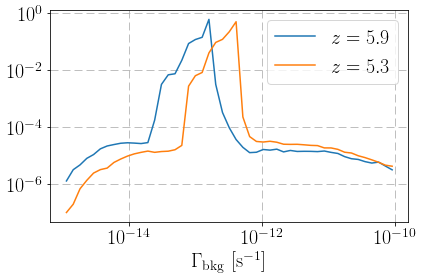

In [29]:
val_z525,bine_z525=np.histogram(gammalist_z525,bins=np.logspace(-15,-10),weights=dr_z525)
plt.plot((bine[1:]+bine[:-1])/2.,val/np.sum(val),label=r"$z=5.9$")
plt.plot((bine_z525[1:]+bine_z525[:-1])/2.,val_z525/np.sum(val_z525),label=r"$z=5.3$")
plt.loglog()
plt.legend()
plt.xlabel(r"$\Gamma_{\rm bkg} \ [\rm s^{-1}]$")
plt.tight_layout()
plt.grid(dashes=(10,5))
plt.savefig("Gamma_scatter_evolution.pdf")

In [11]:
plt.rcParams["text.usetex"]=True
plt.rcParams["axes.labelsize"]=24
plt.rcParams["xtick.labelsize"]=20
plt.rcParams["ytick.labelsize"]=20
plt.rcParams["legend.fontsize"]=20
plt.rcParams["legend.title_fontsize"]=20

5.2 [6.41502438e-13]
5.4 [5.39523469e-13]
5.6 [4.5375599e-13]
5.9 [3.20956689e-13]
6.1 [2.54797877e-13]
6.4 [1.90933671e-13]
6.8 [1.27480549e-13]
7.3 [4.51144955e-14]
7.9 [1.02970328e-20]


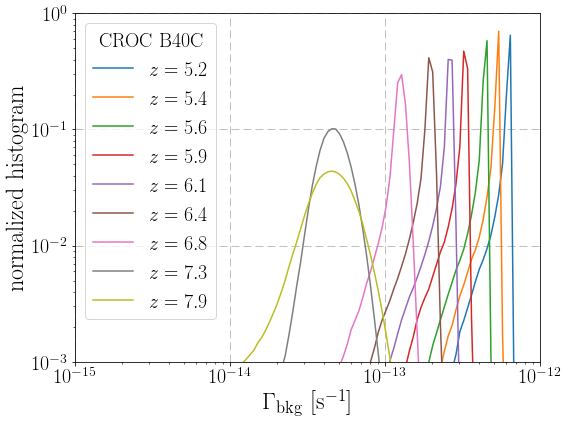

In [19]:
plt.figure(figsize=(8,6))
for z in ["5.2","5.4","5.6","5.9","6.1","6.4","6.8","7.3","7.9"]:
    gammalist=np.load("B40C_unisample_gamma_bkg_z="+z+".npy")
    gammalist[gammalist<1e-20]=1.01e-20
    val,bine=np.histogram(gammalist,bins=np.logspace(-20,-10,400))
    plt.plot((bine[1:]+bine[:-1])/2.,val/np.sum(val),label=r"$z={:.1f}$".format(float(z)))
    print(z,(bine[1:]+bine[:-1])[val==val.max()]/2.)
plt.xscale("log")
plt.yscale("log")
plt.legend(title=r"$\rm CROC \ B40C$", loc="upper left")
plt.xlabel(r"$\Gamma_{\rm bkg} \ [\rm s^{-1}]$")
plt.ylabel(r"$\rm normalized \ histogram$")

plt.ylim(1e-3,1)
plt.xlim(1e-15,1e-12)
plt.grid(dashes=(10,5))
plt.tight_layout()
plt.savefig("B40C_Gamma_bkg_hist_evo_limit3.pdf")

5.2 [3.60223254e-13]
5.4 [2.85970423e-13]
5.7 [2.02276383e-13]
5.9 [1.51576507e-13]
6.1 [1.1358438e-13]
6.4 [7.58368028e-14]
6.8 [2.25716977e-14]
7.3 [1.02970328e-20]
8.0 [1.02970328e-20]


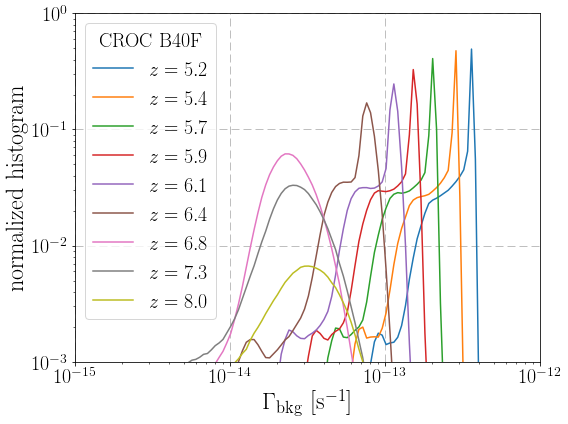

In [17]:
plt.figure(figsize=(8,6))
for z in ["5.2","5.4","5.7","5.9","6.1","6.4","6.8","7.3","8.0"]:
    gammalist=np.load("unisample_gamma_bkg_z="+z+".npy")
    gammalist[gammalist<1e-20]=1.01e-20
    val,bine=np.histogram(gammalist,bins=np.logspace(-20,-10,400))
    plt.plot((bine[1:]+bine[:-1])/2.,val/np.sum(val),label=r"$z={:.1f}$".format(float(z)))
    print(z,(bine[1:]+bine[:-1])[val==val.max()]/2.)
plt.xscale("log")
plt.yscale("log")
plt.legend(title=r"$\rm CROC \ B40F$", loc="upper left")
plt.xlabel(r"$\Gamma_{\rm bkg} \ [\rm s^{-1}]$")
plt.ylabel(r"$\rm normalized \ histogram$")

plt.ylim(1e-3,1)
plt.xlim(1e-15,1e-12)
plt.grid(dashes=(10,5))
plt.tight_layout()
plt.savefig("Gamma_bkg_hist_evo.pdf")

5.2 [3.60223254e-13]
5.4 [2.85970423e-13]
5.7 [2.02276383e-13]
5.9 [1.51576507e-13]
6.1 [1.1358438e-13]
6.4 [7.58368028e-14]
6.8 [2.39126046e-14]
7.3 [1.02970328e-20]
8.0 [1.02970328e-20]
8.9 [1.02970328e-20]


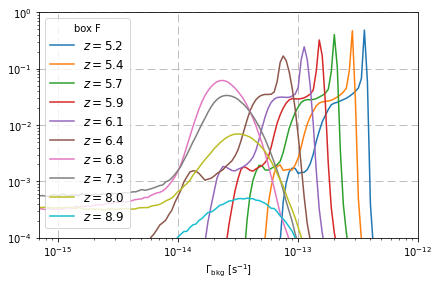

In [6]:
for z in ["5.2","5.4","5.7","5.9","6.1","6.4","6.8","7.3","8.0","8.9"]:
    gammalist=np.load("gamma_bkg_z="+z+".npy")
    gammalist[gammalist<1e-20]=1.01e-20
    dr=np.load("gamma_bkg_z="+z+"_dr.npy")
    val,bine=np.histogram(gammalist,bins=np.logspace(-20,-10,400),weights=dr)
    plt.plot((bine[1:]+bine[:-1])/2.,val/np.sum(val),label=r"$z={:.1f}$".format(float(z)))
    print(z,(bine[1:]+bine[:-1])[val==val.max()]/2.)
plt.loglog()
plt.legend(title="box F", fontsize=12,loc="upper left")
plt.xlabel(r"$\Gamma_{\rm bkg} \ [\rm s^{-1}]$")
plt.tight_layout()
plt.ylim(1e-4,1)
plt.xlim(7e-16,1e-12)
plt.grid(dashes=(10,5))

[8.26595874e-14 1.47204064e-13 2.20474515e-13 3.49832094e-13
 3.70614414e-13 3.92631340e-13 3.92631340e-13]


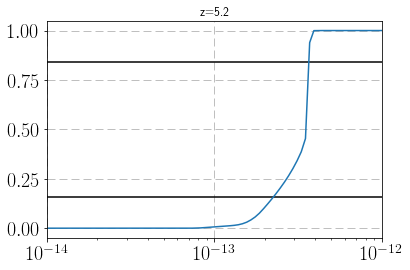

[6.19412478e-14 1.10307874e-13 1.75028096e-13 2.77721193e-13
 2.94219653e-13 2.94219653e-13 3.11698230e-13]


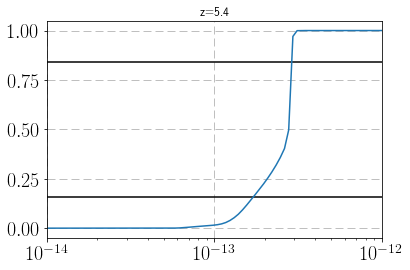

[4.13562692e-14 8.26595874e-14 1.23803188e-13 1.96441428e-13
 2.08111337e-13 2.20474515e-13 2.33572147e-13]


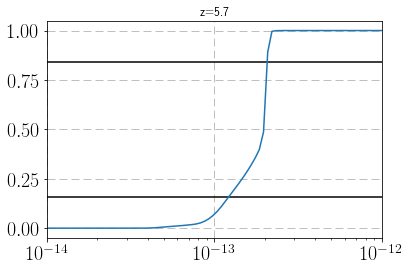

[3.09904634e-14 6.19412478e-14 9.27723476e-14 1.47204064e-13
 1.55948950e-13 1.65213341e-13 1.85425913e-13]


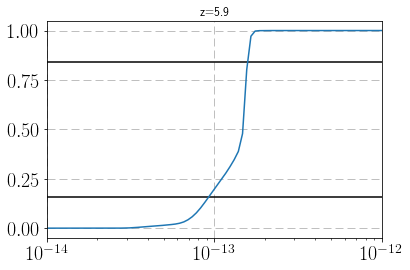

[2.06913808e-14 4.38131027e-14 6.95192796e-14 1.10307874e-13
 1.16860886e-13 1.31157910e-13 1.38949549e-13]


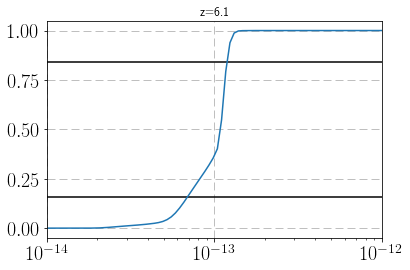

[7.75754513e-15 2.60639420e-14 4.91732965e-14 7.36491807e-14
 8.26595874e-14 9.27723476e-14 1.10307874e-13]


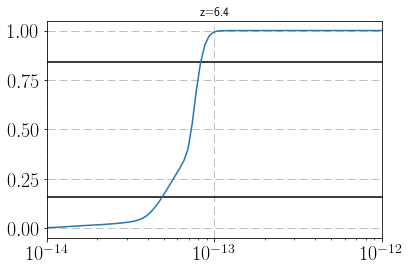

[1.05940656e-20 2.68269580e-19 8.70662068e-15 2.19205845e-14
 3.28315001e-14 4.38131027e-14 6.56209641e-14]


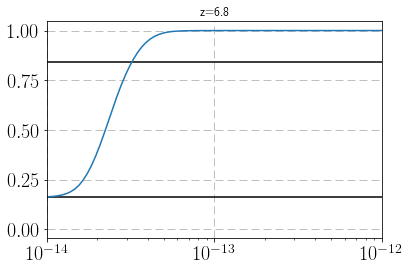

[1.05940656e-20 1.05940656e-20 1.58672350e-20 1.38149996e-14
 3.28315001e-14 4.91732965e-14 7.80244249e-14]


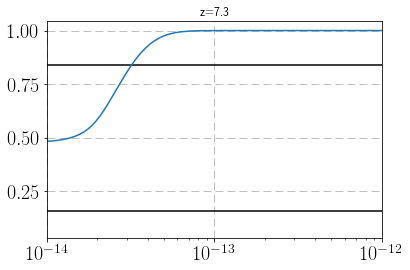

[1.05940656e-20 1.05940656e-20 1.05940656e-20 1.05940656e-20
 1.14855124e-16 4.64158883e-14 8.26595874e-14]


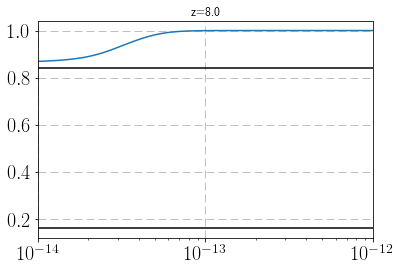

[1.05940656e-20 1.05940656e-20 1.05940656e-20 1.05940656e-20
 1.05940656e-20 6.05277998e-18 6.56209641e-14]


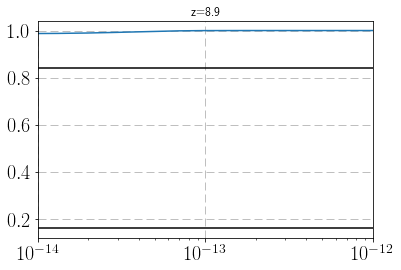

In [34]:
outsave=[]


for z in ["5.2","5.4","5.7","5.9","6.1","6.4","6.8","7.3","8.0","8.9"]:
    gammalist=np.load("gamma_bkg_z="+z+".npy")
    gammalist[gammalist<1e-20]=1.01e-20
    dr=np.load("gamma_bkg_z="+z+"_dr.npy")
    val,bine=np.histogram(gammalist,bins=np.logspace(-20,-10,400),weights=dr)
    
    cdf=np.cumsum(val)/np.cumsum(val)[-1]
    plt.plot(bine[1:],cdf)
    plt.
    perlist=np.array([bine[1:][np.argmin(np.abs(cdf-percentile))] \
                      for percentile in [0.0015, 0.025, 0.16, 0.5, 0.84, 0.975, 0.9985]])
    print(perlist)
    outsave.append(perlist)
    
    plt.xlim(1e-14,1e-12)
    plt.xscale("log")
    plt.title("z="+str(z))
    plt.grid(dashes=(10,5))
    plt.hlines(0.16,1e-14,1e-12)
    plt.hlines(0.84,1e-14,1e-12)
    plt.show()
    
np.savetxt("gamma_percentile.txt",outsave,fmt="%6.4e")

In [12]:
type(gammalist)

numpy.ndarray

[2.62147890e-13 4.15956216e-13 5.88062599e-13 6.22997373e-13
 6.60007502e-13 6.60007502e-13 6.60007502e-13]


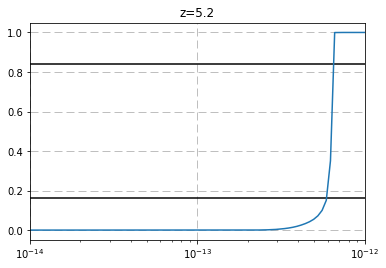

[2.20474515e-13 3.49832094e-13 4.94578905e-13 5.23960135e-13
 5.55086803e-13 5.55086803e-13 5.55086803e-13]


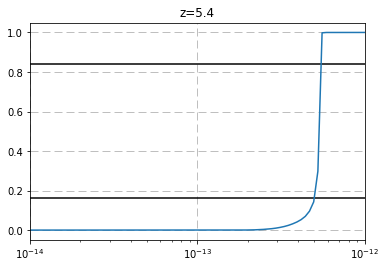

[1.75028096e-13 2.94219653e-13 4.15956216e-13 4.40666743e-13
 4.66845237e-13 4.66845237e-13 4.66845237e-13]


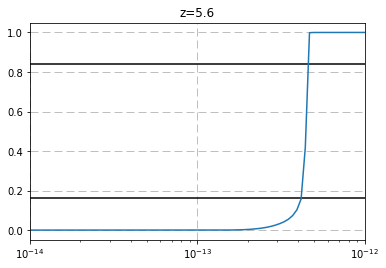

[1.23803188e-13 2.08111337e-13 3.11698230e-13 3.30215148e-13
 3.49832094e-13 3.49832094e-13 3.49832094e-13]


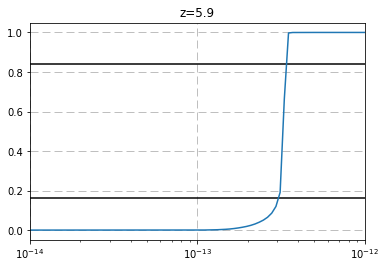

[9.82836333e-14 1.65213341e-13 2.47447864e-13 2.62147890e-13
 2.77721193e-13 2.77721193e-13 2.94219653e-13]


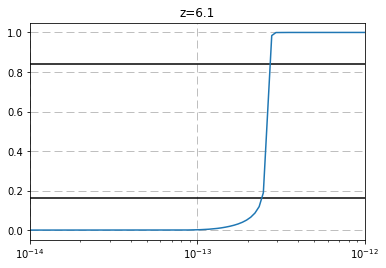

[6.95192796e-14 1.23803188e-13 1.75028096e-13 1.96441428e-13
 2.08111337e-13 2.08111337e-13 2.33572147e-13]


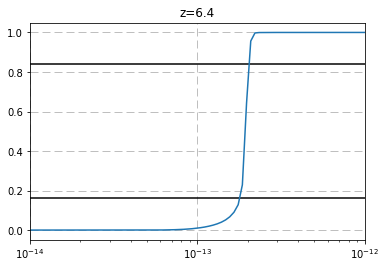

[4.13562692e-14 8.26595874e-14 1.10307874e-13 1.23803188e-13
 1.31157910e-13 1.47204064e-13 1.65213341e-13]


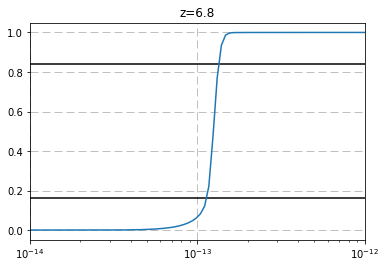

[1.05940656e-20 2.14203749e-18 3.68481798e-14 4.64158883e-14
 5.84678728e-14 6.95192796e-14 9.27723476e-14]


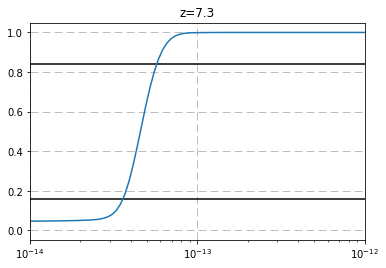

[1.05940656e-20 1.05940656e-20 1.05940656e-20 3.28315001e-14
 5.51892683e-14 7.80244249e-14 1.10307874e-13]


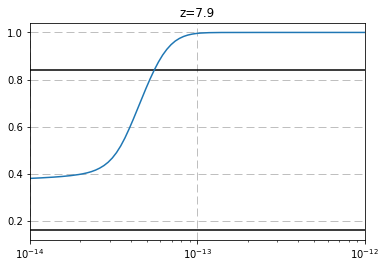

[1.05940656e-20 1.05940656e-20 1.05940656e-20 1.05940656e-20
 2.99357729e-20 5.51892683e-14 1.04122326e-13]


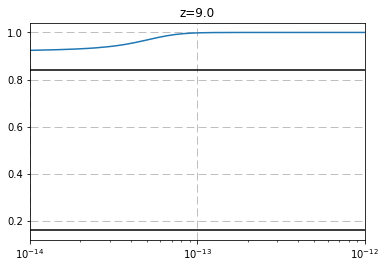

In [6]:
outsave=[]
for z in ["5.2","5.4","5.6","5.9","6.1","6.4","6.8","7.3","7.9","9.0"]:
    gammalist=np.load("B40C_unisample_gamma_bkg_z="+z+".npy")
    gammalist[gammalist<1e-20]=1.01e-20
#     loadall.append(list(gammalist))
    val,bine=np.histogram(gammalist,bins=np.logspace(-20,-10,400))
    
    cdf=np.cumsum(val)/np.cumsum(val)[-1]
    plt.plot(bine[1:],cdf)
    perlist=np.array([bine[1:][np.argmin(np.abs(cdf-percentile))] \
                      for percentile in [0.0015, 0.025, 0.16, 0.5, 0.84, 0.975, 0.9985]])
    print(perlist)
    outsave.append(perlist)
    
    plt.xlim(1e-14,1e-12)
    plt.xscale("log")
    plt.title("z="+str(z))
    plt.grid(dashes=(10,5))
    plt.hlines(0.16,1e-14,1e-12)
    plt.hlines(0.84,1e-14,1e-12)
    plt.show()
    
np.savetxt("B40C_unisample_gamma_percentile.txt",outsave,fmt="%6.4e")

[1.23803188e-13 1.96441428e-13 3.30215148e-13 4.66845237e-13
 4.94578905e-13 5.23960135e-13 5.23960135e-13]


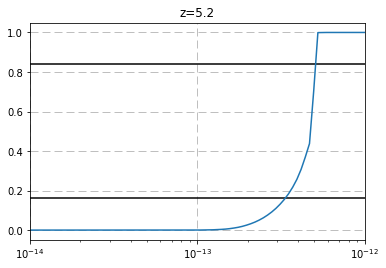

[9.27723476e-14 1.47204064e-13 2.62147890e-13 3.70614414e-13
 3.92631340e-13 4.15956216e-13 4.15956216e-13]


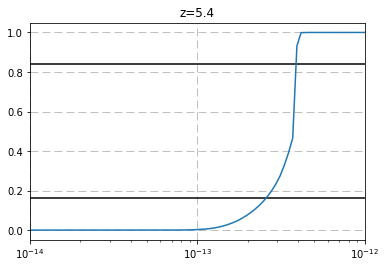

[7.36491807e-14 1.16860886e-13 1.96441428e-13 2.94219653e-13
 3.11698230e-13 3.30215148e-13 3.49832094e-13]


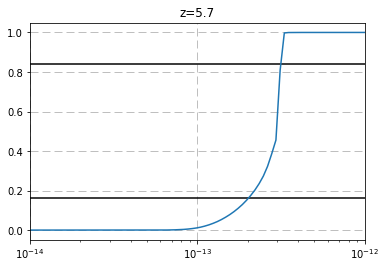

[5.51892683e-14 8.75701089e-14 1.55948950e-13 2.20474515e-13
 2.47447864e-13 2.47447864e-13 2.62147890e-13]


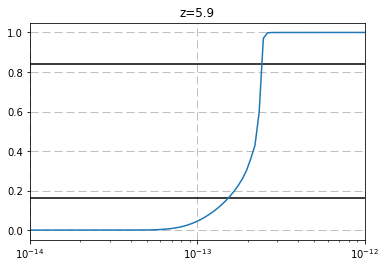

[3.90372033e-14 6.19412478e-14 1.10307874e-13 1.65213341e-13
 1.85425913e-13 1.85425913e-13 2.08111337e-13]


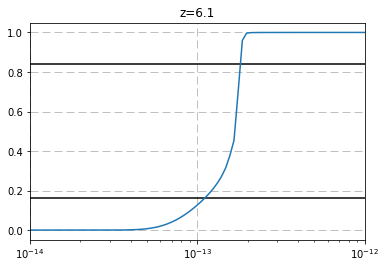

[2.06913808e-14 3.68481798e-14 7.80244249e-14 1.16860886e-13
 1.31157910e-13 1.38949549e-13 1.55948950e-13]


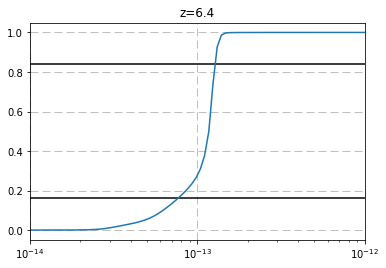

[8.70662068e-15 2.92526634e-14 5.20945127e-14 7.80244249e-14
 8.75701089e-14 9.82836333e-14 1.16860886e-13]


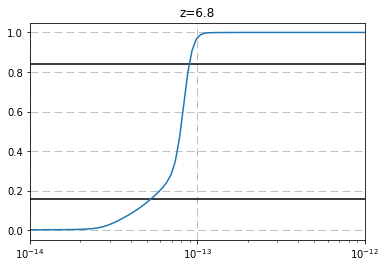

[1.05940656e-20 7.53690398e-20 6.12304454e-16 3.47819065e-14
 4.64158883e-14 6.19412478e-14 8.75701089e-14]


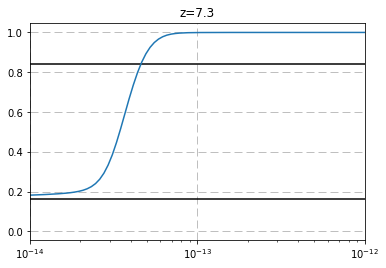

[1.05940656e-20 1.05940656e-20 1.05940656e-20 6.71533479e-20
 4.13562692e-14 6.56209641e-14 1.04122326e-13]


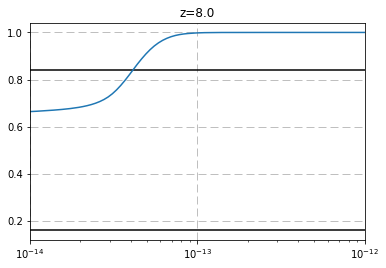

[1.05940656e-20 1.05940656e-20 1.05940656e-20 1.05940656e-20
 1.05940656e-20 2.92526634e-14 9.27723476e-14]


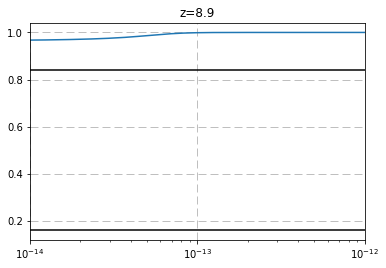

In [3]:
outsave=[]
for z in ["5.2","5.4","5.7","5.9","6.1","6.4","6.8","7.3","8.0","8.9"]:
    gammalist=np.load("B40E_unisample_gamma_bkg_z="+z+".npy")
    gammalist[gammalist<1e-20]=1.01e-20
#     loadall.append(list(gammalist))
    val,bine=np.histogram(gammalist,bins=np.logspace(-20,-10,400))
    
    cdf=np.cumsum(val)/np.cumsum(val)[-1]
    plt.plot(bine[1:],cdf)
    perlist=np.array([bine[1:][np.argmin(np.abs(cdf-percentile))] \
                      for percentile in [0.0015, 0.025, 0.16, 0.5, 0.84, 0.975, 0.9985]])
    print(perlist)
    outsave.append(perlist)
    
    plt.xlim(1e-14,1e-12)
    plt.xscale("log")
    plt.title("z="+str(z))
    plt.grid(dashes=(10,5))
    plt.hlines(0.16,1e-14,1e-12)
    plt.hlines(0.84,1e-14,1e-12)
    plt.show()
    
np.savetxt("B40E_unisample_gamma_percentile.txt",outsave,fmt="%6.4e")

In [7]:
perc=np.loadtxt("unisample_gamma_percentile.txt")
print(perc[:,3])
print((perc[:,3]-perc[:,2],perc[:,4]-perc[:,3]))

[3.4983e-13 2.7772e-13 1.9644e-13 1.4720e-13 1.1031e-13 7.3649e-14
 2.1921e-14 1.3040e-14 1.0594e-20 1.0594e-20]
(array([1.29360000e-13, 1.02690000e-13, 7.26400000e-14, 5.44280000e-14,
       4.07910000e-14, 2.44760000e-14, 1.37026000e-14, 1.30399832e-14,
       0.00000000e+00, 0.00000000e+00]), array([2.07800000e-14, 1.65000000e-14, 1.16700000e-14, 8.75000000e-15,
       6.55000000e-15, 9.01100000e-15, 1.09110000e-14, 1.79500000e-14,
       1.36549406e-16, 0.00000000e+00]))


In [3]:
perc_B40C=np.loadtxt("B40C_unisample_gamma_percentile.txt")

[1.29360000e-13 1.02690000e-13 7.26400000e-14 5.44280000e-14
 4.07910000e-14 2.44760000e-14 1.37026000e-14 1.30399832e-14
 0.00000000e+00 0.00000000e+00] [2.07800000e-14 1.65000000e-14 1.16700000e-14 8.75000000e-15
 6.55000000e-15 9.01100000e-15 1.09110000e-14 1.79500000e-14
 1.36549406e-16 0.00000000e+00]
[3.4983e-13 2.7772e-13 1.9644e-13 1.4720e-13 1.1031e-13 7.3649e-14
 2.1921e-14 1.3040e-14 1.0594e-20 1.0594e-20]
(array([1.29360000e-13, 1.02690000e-13, 7.26400000e-14, 5.44280000e-14,
       4.07910000e-14, 2.44760000e-14, 1.37026000e-14, 1.30399832e-14,
       0.00000000e+00, 0.00000000e+00]), array([2.07800000e-14, 1.65000000e-14, 1.16700000e-14, 8.75000000e-15,
       6.55000000e-15, 9.01100000e-15, 1.09110000e-14, 1.79500000e-14,
       1.36549406e-16, 0.00000000e+00]))


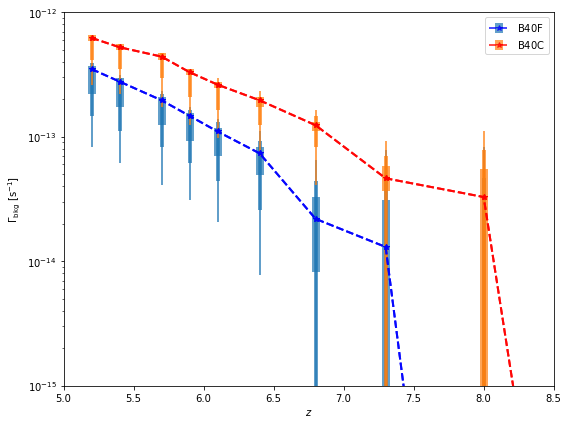

In [5]:
plt.figure(figsize=(8,6))

zuni=[5.2,5.4,5.7,5.9,6.1,6.4,6.8,7.3,8.0,8.9]

print(perc[:,3]-perc[:,2],perc[:,4]-perc[:,3])
print(perc[:,3])

plt.errorbar(zuni,perc[:,3],yerr=(perc[:,3]-perc[:,2],perc[:,4]-perc[:,3]),fmt="*--",lw=2,elinewidth=8,label=r"$\rm B40F$",color="b",ecolor="tab:blue",alpha=0.7)

print((perc[:,3]-perc[:,2],perc[:,4]-perc[:,3]))

plt.errorbar(zuni,perc[:,3],yerr=(perc[:,3]-perc[:,1],perc[:,5]-perc[:,3]),fmt="*--",lw=2,elinewidth=4,color="b",ecolor="tab:blue",alpha=0.7)

plt.errorbar(zuni,perc[:,3],yerr=(perc[:,3]-perc[:,0],perc[:,6]-perc[:,3]),fmt="*--",lw=2,elinewidth=2,color="b",ecolor="tab:blue",alpha=0.7)


plt.errorbar(zuni,perc_B40C[:,3],yerr=(perc_B40C[:,3]-perc_B40C[:,2],perc_B40C[:,4]-perc_B40C[:,3]),fmt="*--",lw=2,elinewidth=8,label=r"$\rm B40C$",color="r",ecolor="tab:orange",alpha=0.7)

plt.errorbar(zuni,perc_B40C[:,3],yerr=(perc_B40C[:,3]-perc_B40C[:,1],perc_B40C[:,5]-perc_B40C[:,3]),fmt="*--",lw=2,elinewidth=4,color="r",ecolor="tab:orange",alpha=0.7)

plt.errorbar(zuni,perc_B40C[:,3],yerr=(perc_B40C[:,3]-perc_B40C[:,0],perc_B40C[:,6]-perc_B40C[:,3]),fmt="*--",lw=2,elinewidth=2,color="r",ecolor="tab:orange",alpha=0.7)

plt.legend()
plt.yscale("log")
plt.ylim(1e-15,1e-12)
plt.xlim(5,8.5)
plt.ylabel(r"$\Gamma_{\rm bkg} \ [\rm s^{-1}]$")
plt.xlabel(r"$z$")
plt.tight_layout()
# plt.savefig("gamma_scatter_evolution_2boxes.pdf")

In [110]:
downsample=[]
for z in ["5.2","5.4","5.7","5.9","6.1","6.4","6.8","7.3","8.0","8.9"]:
    gammalist=np.load("unisample_gamma_bkg_z="+z+".npy")
    gammalist[gammalist<1e-20]=1e-20
    print(len(gammalist))
    gammalist.sort()
    downsample.append(np.log10(gammalist[::100]))
    

4801000
4801000
4801000
4801000
4801000
4801000
4801000
4801000
4801000
4801000


[0.23541320903515897, 0.23541320903515897, 0.23541320903515897, 0.23541320903515897, 0.23541320903515897, 0.23541320903515897, 0.23541320903515897, 0.23541320903515897, 0.23541320903515897, 0.23541320903515897]


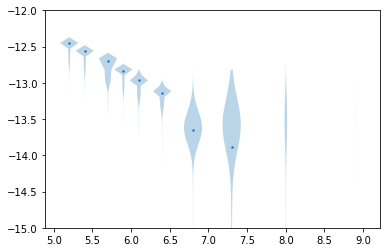

In [111]:
width=[]
for i in range(len(downsample)):
    val,edge=np.histogram(downsample,bins=np.linspace(-20,-10,100))
    width.append(2e4/val.max())
print(width)

plt.violinplot(downsample,zuni,showextrema=False,showmedians=False,widths=width)#,\
#                quantiles=[np.array([0.0015, 0.025, 0.16, 0.5, 0.84, 0.975, 0.9985])]*10)
plt.ylim(-15,-12)
plt.scatter(zuni,np.median(downsample,axis=1),s=2)

In [80]:
plt.violinplot??

In [112]:
for i in range(10):
    print(np.shape(downsample[i]))

(48010,)
(48010,)
(48010,)
(48010,)
(48010,)
(48010,)
(48010,)
(48010,)
(48010,)
(48010,)


In [2]:
gammalist=np.load("unisample_gamma_bkg_z=5.2.npy")

In [7]:
sample_dist=np.linspace(1,49,4801)

In [8]:
len(sample_dist)

4801

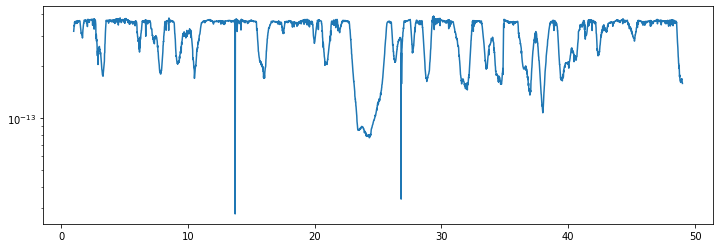

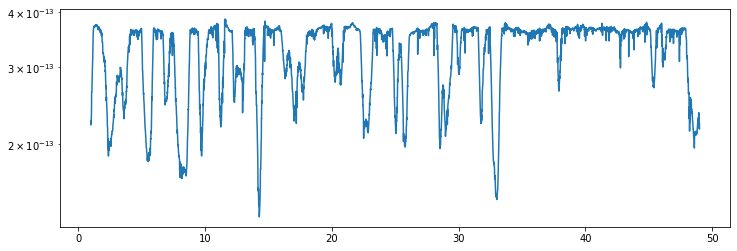

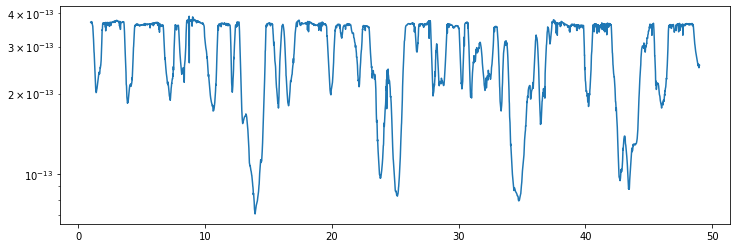

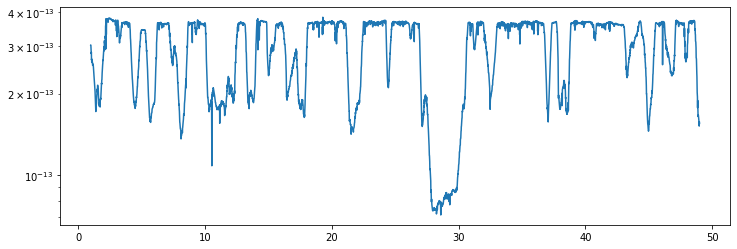

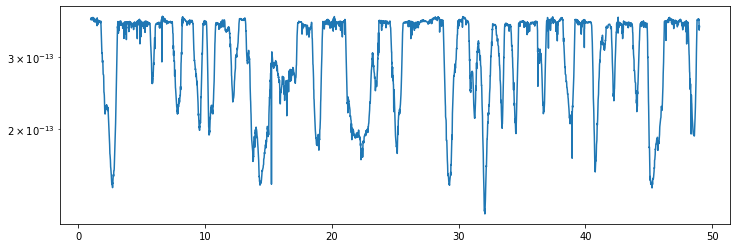

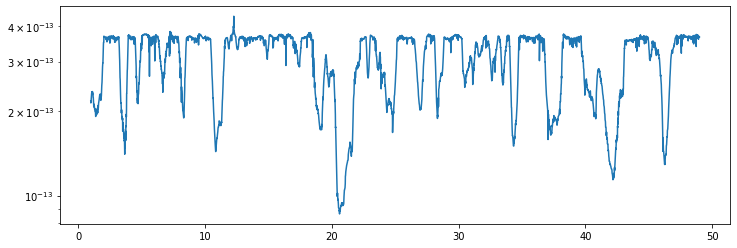

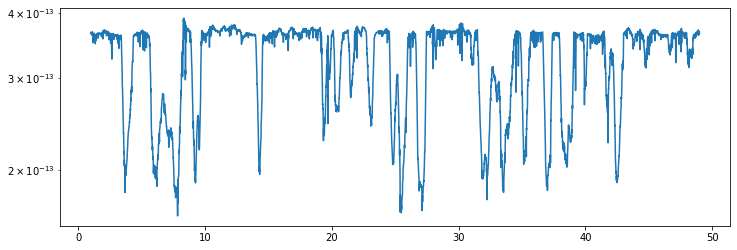

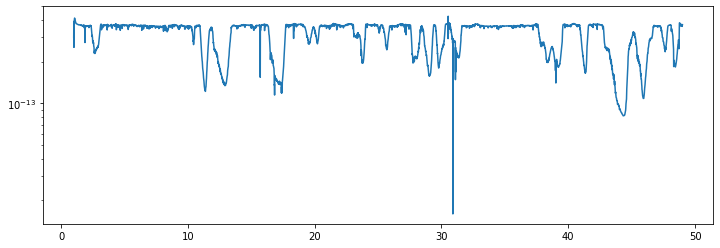

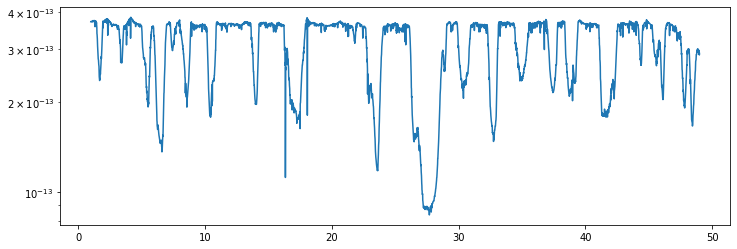

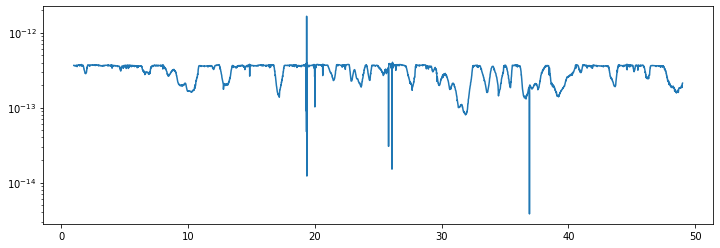

In [12]:
for i in range(10):
    plt.figure(figsize=(12,4))
    plt.plot(sample_dist,gammalist[i*len(sample_dist):(i+1)*len(sample_dist)])
    plt.plot()
    plt.yscale("log")
    plt.show()

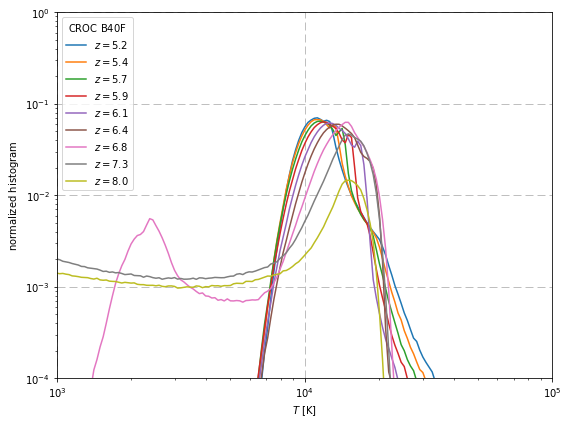

In [11]:
## plot temperature
plt.figure(figsize=(8,6))
for z in ["5.2","5.4","5.7","5.9","6.1","6.4","6.8","7.3","8.0"]:
    gammalist=np.load("unisample_T_z="+z+".npy")
    val,bine=np.histogram(gammalist,bins=np.logspace(1,6,400))
    plt.plot((bine[1:]+bine[:-1])/2.,val/np.sum(val),label=r"$z={:.1f}$".format(float(z)))
plt.xscale("log")
plt.yscale("log")
plt.legend(title=r"$\rm CROC \ B40F$", loc="upper left")
plt.xlabel(r"$T \ [\rm K]$")
plt.ylabel(r"$\rm normalized \ histogram$")
plt.xlim(1e3,1e5)
plt.ylim(1e-4,1)
plt.grid(dashes=(10,5))
plt.tight_layout()
